# Car Regression

**We will perform data cleaning on a kaggle dataset on used cars, some exploratory data anlysis and finally develop some models (ML and ANN) for price prediction**


In [1]:
import pandas as pd
import numpy as np
from copy import copy
import summarytools as st
from datetime import datetime

# for correlation analysis 
import dcor
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as smimport 

#  For plotting and outlier detection
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import zscore


# Tensorflow is a specialty library for ANN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor


2024-12-22 13:08:08.395098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734865688.549172    9067 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734865688.602057    9067 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 13:08:08.988254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import sets
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

In [3]:
st.dfSummary(trainset)

In [4]:
# We could do some modifications to data types to make the data smaller in memory like  assign clean_title and accident to categorical with pd.astype()
# Since it is already a small sample, we do not have to necessarily do adjustments 
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [5]:
trainset.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


## We definately have entries that are inconsistent with the rest of data. We should check if:
- clean title and accident features are coherent for all entries
- If Tesla cars have Electricity as fuel type
- Fix missing values

**Finally define the features we will use in our mdoel**

**Clean Title**

In [6]:
trainset.loc[trainset['clean_title'].isna(), 'clean_title'] = 'No'

In [7]:
# convert clean titles that were falsely declared No to Yes | No accidents -> clean_title = Yes
trainset.loc[(trainset['clean_title'] == 'No') & (trainset['accident'] == 'None reported'), 'clean_title'] = 'Yes'

**Accidents**

In [8]:
trainset.loc[(trainset['accident'].isna()) & (trainset['clean_title'] == 'Yes'), 'accident'] = 'None reported'

In [9]:
# accidents -> No , clean_title=No
trainset[(trainset['accident'] == 'None reported') & (trainset['clean_title'] == 'No')] 

Empty DataFrame
Columns: [id, brand, model, model_year, milage, fuel_type, engine, transmission, ext_col, int_col, accident, clean_title, price]
Index: []

In [10]:
trainset[(trainset['accident'] == 'At least 1 accident or damage') & (trainset['clean_title'] == 'Yes')]

Empty DataFrame
Columns: [id, brand, model, model_year, milage, fuel_type, engine, transmission, ext_col, int_col, accident, clean_title, price]
Index: []

In [11]:
trainset.loc[(trainset['accident'].isna()) & (trainset['clean_title'] == 'No'), 'accident'] = 'At least 1 accident or damage'
trainset.loc[(trainset['accident'] == 'At least 1 accident or damage') & (trainset['clean_title'] == 'Yes'), 'clean_title'] = 'No'

In [12]:
trainset.isna().sum()

id                 0
brand              0
model              0
model_year         0
milage             0
fuel_type       5083
engine             0
transmission       0
ext_col            0
int_col            0
accident           0
clean_title        0
price              0
dtype: int64

In [13]:
trainset.loc[trainset.engine.str.contains('Gasoline', case=False, na=False), 'fuel_type'] = 'Gasoline'

**Fuel type**

# Fix Missing Values

In [14]:
# Electric

trainset.loc[(trainset['fuel_type'].isna()) & (trainset['engine'].str.contains("Electric", case=False, na=False)), 'fuel_type'] = 'Electric' 

trainset.loc[(trainset['fuel_type'].isna()) & (trainset['engine'].str.contains("Battery", case=False, na=False)), 'fuel_type'] = 'Electric'

trainset.loc[(trainset['fuel_type'].isna()) & (trainset['brand'] == 'Tesla'), 'fuel_type'] = 'Electric' 

trainset.loc[(trainset['fuel_type'].isna()) & (trainset['engine'].str.contains("Battery", case=False, na=False)), 'fuel_type'] = 'Electric'

trainset.loc[(trainset['brand'] == 'Tesla') & (trainset['fuel_type'] != 'Electric'), 'fuel_type'] = 'Electric' 

# Flex & Hybrid

trainset.loc[(trainset['fuel_type'].isna()) & (trainset['engine'].str.contains("Flex", case=False, na=False)), 'fuel_type'] = 'Flex' 

trainset.loc[trainset['fuel_type'].str.contains("Flex", case=False, na=False), 'fuel_type'] = 'Flex' 

trainset.loc[(trainset['fuel_type'].isna()) & (trainset['engine'].str.contains("Dual", case=False, na=False)), 'fuel_type'] = 'Hybrid' 

trainset.loc[(trainset['fuel_type'].isna()) & (trainset['engine'].str.contains("Hybrid", case=False, na=False)), 'fuel_type'] = 'Hybrid' 

trainset.loc[trainset['fuel_type'].str.contains("Plug", case=False, na=False), 'fuel_type'] = 'Hybrid' 

# Diesel

trainset.loc[(trainset['fuel_type'].isna()) & (trainset['engine'].str.contains("Diesel", case=False, na=False)), 'fuel_type'] = 'Diesel' 

# Gasoline

trainset.loc[trainset.engine.str.contains(r'^\d+\.\d+L$'), 'fuel_type'] = 'Gasoline'

trainset[(trainset['fuel_type'].isna()) & trainset.fuel_type.str.contains('Gasoline', case=False, na=False)] = 'Gasoline'

# Arbitrarily change all NULL values to Gasoline
trainset.loc[trainset['fuel_type'].isna(), 'fuel_type'] = 'Gasoline'

# –
trainset = trainset[(trainset['fuel_type'] != '–') & (trainset['fuel_type'] != 'not supported')].reset_index(drop=True)

# Filter outliers with zscore
z_scores = np.abs(zscore(trainset.select_dtypes(include='number')))

# This is a first layer outlier removal. We will use z-score to filter out values greater than 2 standard deviations from the mean.
# Keep in mind that z-score assumes normal distribution on the dataset.

# Another criterion could be Median Absolute Deviation (MAD)

# Filter out rows where any z-score is above the threshold of 2
outlier_mask = (z_scores >= 2).any(axis=1)
trainset = trainset[~outlier_mask]

In [15]:
st.dfSummary(trainset)

In [16]:
trainset.isna().sum()
# We eliminated the null values

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [17]:
print(trainset.fuel_type.unique())

['Gasoline' 'Flex' 'Electric' 'Diesel' 'Hybrid']


In [18]:
print(trainset['fuel_type'].value_counts())

fuel_type
Gasoline    152242
Electric      5263
Flex          4696
Hybrid        3841
Diesel        3357
Name: count, dtype: int64


# PCA for outlier recognition


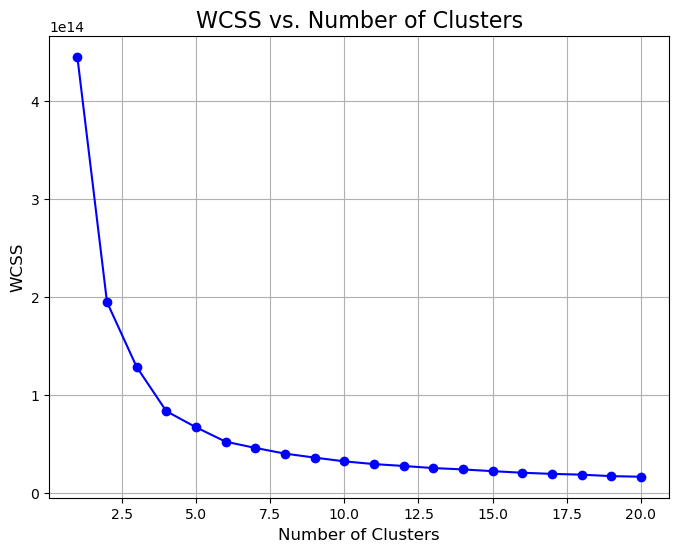

In [19]:
# We will now perform a second laeyr of outlier detection with PCA.

# Caclulate and plot the WCSS score to find the optimal cluster number

wcss = []
for i in range(1, 21):  
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(trainset.select_dtypes(include='number').drop(columns=['model_year','id']))
    wcss.append(kmeans.inertia_) 

    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), wcss, marker='o', color='blue')
plt.title('WCSS vs. Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.grid(True)
plt.show()

# Seems that our data would perform perfect with 7 clusters
#  A more caonical approach would be to pick 4 clusters as we could follow the 'Elbow' rule

/home/admin1997/miniconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


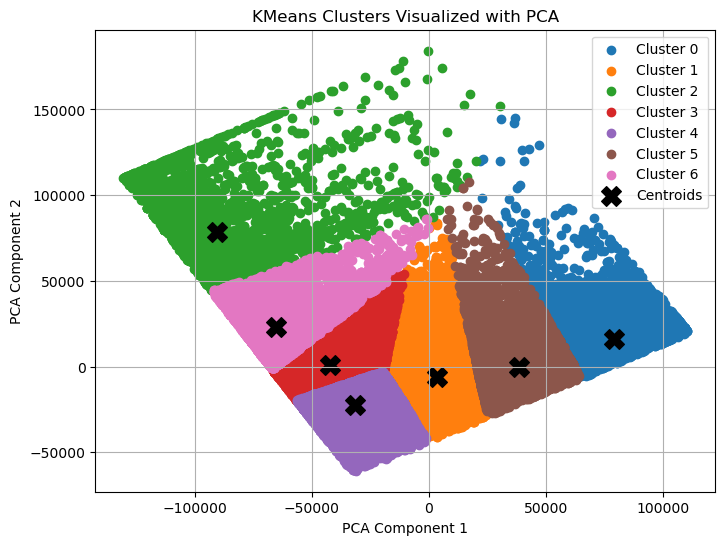

Original data shape: (169399, 3)


In [20]:
# Exclude non-numeric columns as we cannot perform KMeans on qualitative variables and prepare data
data = trainset.select_dtypes(include='number').drop(columns=['model_year', 'id'])

# Apply KMeans clustering for 7 clusters
kmeans = KMeans(n_clusters=7, random_state=42)
cluster_labels = kmeans.fit_predict(data)

# Add cluster labels to the data
data['cluster'] = cluster_labels

# Apply PCA. 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.drop(columns=['cluster']))

# Plot the PCA-reduced data points
plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(
        X_pca[cluster_labels == cluster, 0],  # PCA component 1
        X_pca[cluster_labels == cluster, 1],  # PCA component 2
        label=f"Cluster {cluster}"
    )

# Highlight KMeans cluster centers in PCA space
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
    c='black', marker='X', s=200, label='Centroids'
)

# Add labels and legend
plt.title("KMeans Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

print(f"Original data shape: {data.shape}")

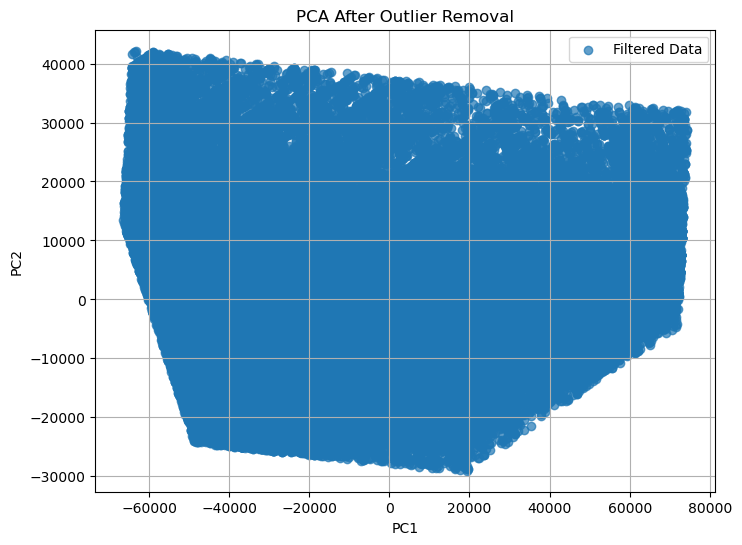

In [21]:
# Ensure data and PCA results have matching indices
data.reset_index(drop=True, inplace=True)  # Reset index of the original dataset
pca_scores = pd.DataFrame(X_pca, index=data.index)  # PCA scores should share the same index

# After performing the PCA we must use some criterion to filter outliers. We wills tick to z-score as earlier.
# Compute Z-scores from PCA-transformed data
z_scores = np.abs(zscore(pca_scores))

# Identify outliers based on Z-score threshold, this time more strict than earlier (1.5 deviations)
outlier_mask = (z_scores >= 1.5).any(axis=1)  # Adjust the threshold if needed
outliers_indices = pca_scores[outlier_mask].index  # Indices of outliers

# Drop outliers from the original dataset
filtered_data = data.drop(index=outliers_indices)

# Reapply PCA on the filtered dataset
X_pca_filtered = pca.fit_transform(filtered_data.drop(columns='cluster', errors='ignore'))

# Visualize the filtered data in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_filtered[:, 0], X_pca_filtered[:, 1], label='Filtered Data', alpha=0.7)
plt.title('PCA After Outlier Removal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()


/home/admin1997/miniconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


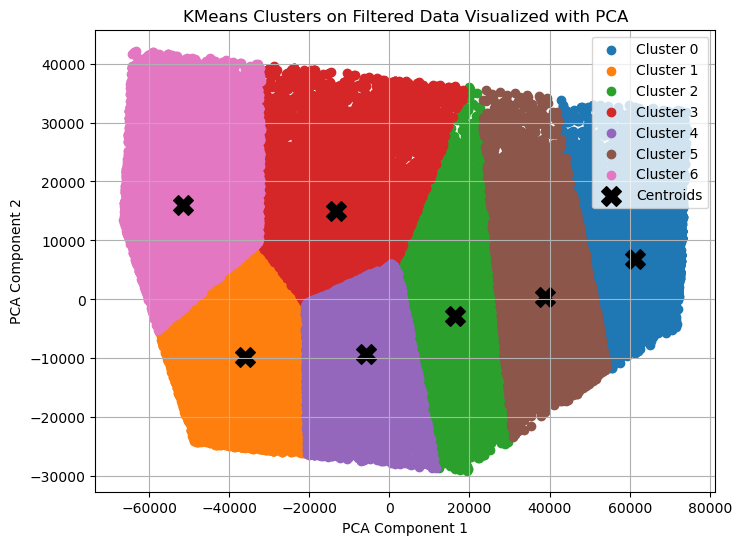

In [22]:
filtered_data_numeric = filtered_data.drop(columns='cluster', errors='ignore')
kmeans_filtered = KMeans(n_clusters=7, random_state=42)
cluster_labels_filtered = kmeans_filtered.fit_predict(filtered_data_numeric)

# Add the new cluster labels to the filtered data
filtered_data['cluster'] = cluster_labels_filtered

# Reapply PCA to the filtered data for visualization
pca = PCA(n_components=2)
X_pca_filtered = pca.fit_transform(filtered_data_numeric)

# Visualize the new clusters
plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels_filtered):
    plt.scatter(
        X_pca_filtered[cluster_labels_filtered == cluster, 0],  # PCA Component 1
        X_pca_filtered[cluster_labels_filtered == cluster, 1],  # PCA Component 2
        label=f"Cluster {cluster}"
    )

# Transform cluster centers into PCA space for visualization
cluster_centers_pca_filtered = pca.transform(kmeans_filtered.cluster_centers_)
plt.scatter(
    cluster_centers_pca_filtered[:, 0], cluster_centers_pca_filtered[:, 1],
    c='black', marker='X', s=200, label='Centroids'
)

# Add plot annotations
plt.title("KMeans Clusters on Filtered Data Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# We managed teo trim outliers further.
trainset = trainset.iloc[filtered_data.index, :]



# Graphs

In [24]:
# Time to perform some exploratory data analysis

print('Min price', trainset['price'].min() )
print('Max price', trainset['price'].max() )


Min price 2000
Max price 102000


/tmp/ipykernel_9067/2598301217.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group, x='model_year', y='count', palette="viridis")


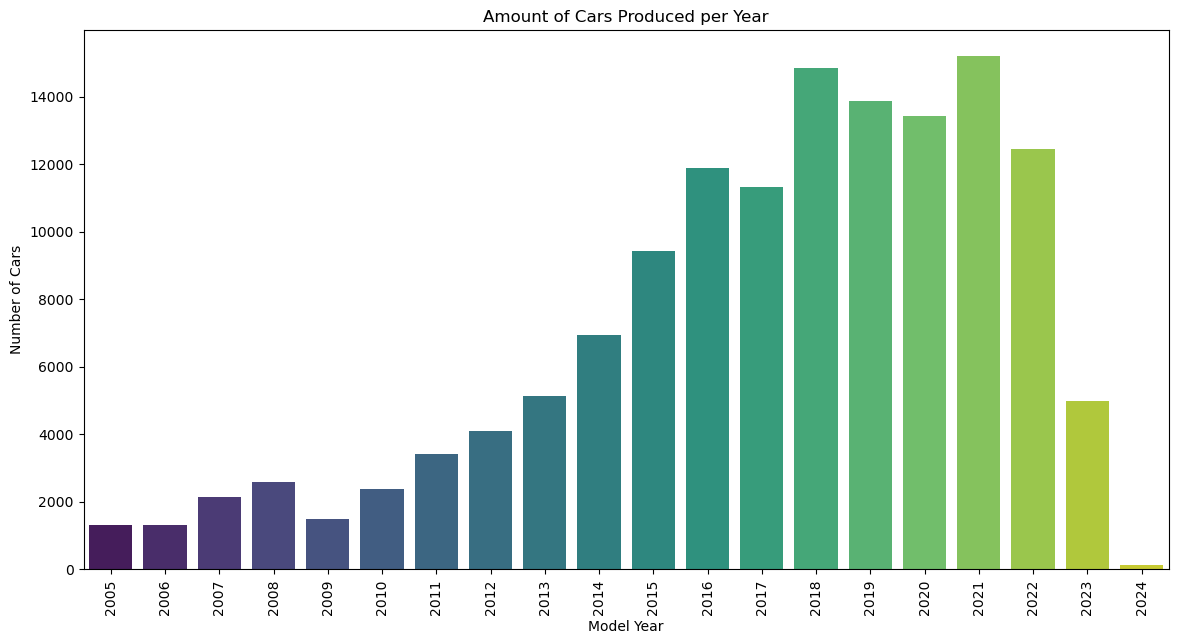

In [25]:
# Group the data and count the occurrences per year
group = trainset.groupby('model_year').size().reset_index(name='count')

# Plot the data
plt.figure(figsize=(14, 7))
sns.barplot(data=group, x='model_year', y='count', palette="viridis")
plt.xticks(rotation=90)
plt.title('Amount of Cars Produced per Year')
plt.xlabel('Model Year')
plt.ylabel('Number of Cars')
plt.show()

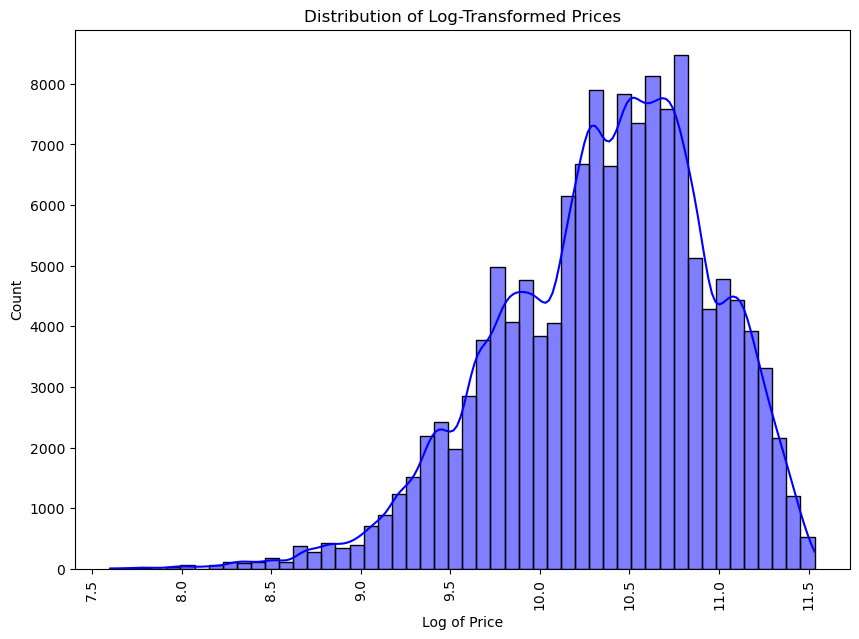

In [28]:
plt.figure(figsize=(10, 7))

sns.histplot(
    data=trainset,
    x=np.log(trainset['price']),
    stat='count',  
    kde=True, 
    bins=50,
    color="blue"
)

# Improve axis labels and title
plt.xticks(rotation=90)
plt.title('Distribution of Log-Transformed Prices')
plt.xlabel('Log of Price')
plt.ylabel('Count')
plt.show()

# Distribution is Poisson like.

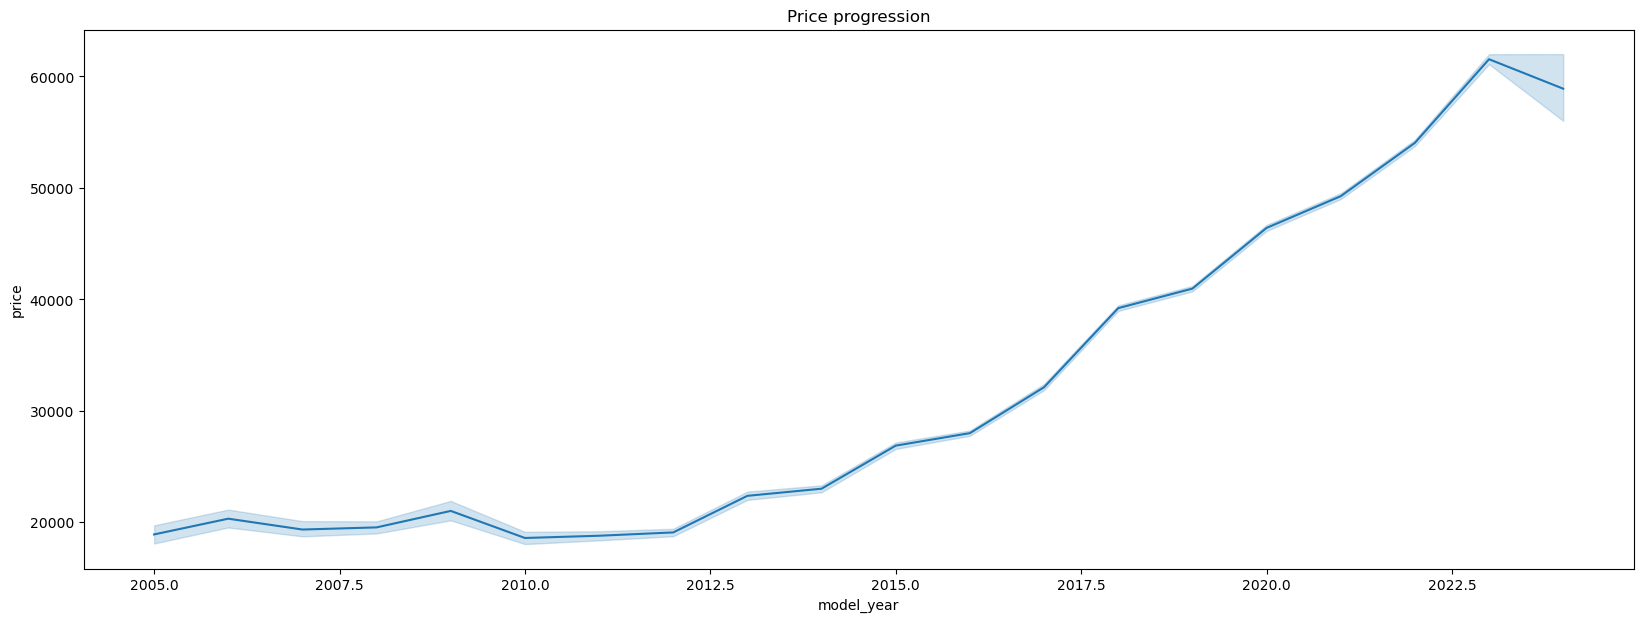

In [29]:
plt.figure(figsize=(20,7))
sns.lineplot(
    data=trainset,
    x='model_year',
    y='price'
)
plt.title('Price progression')
plt.show()

In [30]:

current_year = datetime.now().year
trainset.loc[:, 'model_age'] = current_year - trainset.loc[:, 'model_year']

In [31]:
trainset

id          brand                     model  model_year  milage  \
3            3        Genesis          G90 5.0 Ultimate        2017   19500   
5            5           Audi             A6 2.0T Sport        2018   40950   
6            6           Audi                 A8 L 3.0T        2016   62200   
7            7      Chevrolet        Silverado 1500 1LZ        2016  102604   
8            8           Ford                 F-150 XLT        2020   38352   
...        ...            ...                       ...         ...     ...   
187749  188528       Cadillac     Escalade ESV Platinum        2017   49000   
187750  188529  Mercedes-Benz  AMG C 43 AMG C 43 4MATIC        2018   28600   
187751  188530  Mercedes-Benz    AMG GLC 63 Base 4MATIC        2021   13650   
187752  188531           Audi          S5 3.0T Prestige        2022   13895   
187753  188532        Porsche                Macan Base        2016   59500   

       fuel_type                                             engine  \
3       Gasoline       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
5       Gasoline       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
6       Gasoline      333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
7           Flex  355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
8       Gasoline                    2.7L V6 24V PDI DOHC Twin Turbo   
...          ...                                                ...   
187749  Gasoline       420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel   
187750  Gasoline      385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
187751  Gasoline       469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel   
187752  Gasoline                                               3.0L   
187753  Gasoline       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                          transmission                         ext_col  \
3       Transmission w/Dual Shift Mode                           Black   
5                                  A/T                           White   
6                          8-Speed A/T                           Black   
7                                  A/T                           White   
8                   10-Speed Automatic  Snowflake White Pearl Metallic   
...                                ...                             ...   
187749  Transmission w/Dual Shift Mode                           White   
187750                     8-Speed A/T                           White   
187751                     7-Speed A/T                           White   
187752               1-Speed Automatic       Daytona Gray Pearl Effect   
187753  Transmission w/Dual Shift Mode                           White   

       int_col                                accident clean_title  price  \
3        Black                           None reported         Yes  45000   
5            –                           None reported         Yes  29950   
6        Black                           None reported         Yes  28500   
7         Gray                           None reported         Yes  12500   
8        Black                           None reported         Yes  62890   
...        ...                                     ...         ...    ...   
187749   Beige                           None reported         Yes  27500   
187750   Black  At least 1 accident or damage reported         Yes  30000   
187751   Black                           None reported         Yes  86900   
187752   Black                           None reported         Yes  84900   
187753   Black                           None reported         Yes  28995   

        model_age  
3               7  
5               6  
6               8  
7               8  
8               4  
...           ...  
187749          7  
187750          6  
187751          3  
187752          2  
187753          8  

[138358 rows x 14 columns]

In [32]:
def define_age_group(age):
    if age <= 5:
        return 'New'
    elif age <=15:
        return 'Middle aged'
    else:
        return 'Old'

In [33]:
trainset.loc[:, 'age_group'] = trainset.loc[:, 'model_age',].apply(define_age_group)

In [34]:
trainset

id          brand                     model  model_year  milage  \
3            3        Genesis          G90 5.0 Ultimate        2017   19500   
5            5           Audi             A6 2.0T Sport        2018   40950   
6            6           Audi                 A8 L 3.0T        2016   62200   
7            7      Chevrolet        Silverado 1500 1LZ        2016  102604   
8            8           Ford                 F-150 XLT        2020   38352   
...        ...            ...                       ...         ...     ...   
187749  188528       Cadillac     Escalade ESV Platinum        2017   49000   
187750  188529  Mercedes-Benz  AMG C 43 AMG C 43 4MATIC        2018   28600   
187751  188530  Mercedes-Benz    AMG GLC 63 Base 4MATIC        2021   13650   
187752  188531           Audi          S5 3.0T Prestige        2022   13895   
187753  188532        Porsche                Macan Base        2016   59500   

       fuel_type                                             engine  \
3       Gasoline       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
5       Gasoline       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
6       Gasoline      333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
7           Flex  355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
8       Gasoline                    2.7L V6 24V PDI DOHC Twin Turbo   
...          ...                                                ...   
187749  Gasoline       420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel   
187750  Gasoline      385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
187751  Gasoline       469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel   
187752  Gasoline                                               3.0L   
187753  Gasoline       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                          transmission                         ext_col  \
3       Transmission w/Dual Shift Mode                           Black   
5                                  A/T                           White   
6                          8-Speed A/T                           Black   
7                                  A/T                           White   
8                   10-Speed Automatic  Snowflake White Pearl Metallic   
...                                ...                             ...   
187749  Transmission w/Dual Shift Mode                           White   
187750                     8-Speed A/T                           White   
187751                     7-Speed A/T                           White   
187752               1-Speed Automatic       Daytona Gray Pearl Effect   
187753  Transmission w/Dual Shift Mode                           White   

       int_col                                accident clean_title  price  \
3        Black                           None reported         Yes  45000   
5            –                           None reported         Yes  29950   
6        Black                           None reported         Yes  28500   
7         Gray                           None reported         Yes  12500   
8        Black                           None reported         Yes  62890   
...        ...                                     ...         ...    ...   
187749   Beige                           None reported         Yes  27500   
187750   Black  At least 1 accident or damage reported         Yes  30000   
187751   Black                           None reported         Yes  86900   
187752   Black                           None reported         Yes  84900   
187753   Black                           None reported         Yes  28995   

        model_age    age_group  
3               7  Middle aged  
5               6  Middle aged  
6               8  Middle aged  
7               8  Middle aged  
8               4          New  
...           ...          ...  
187749          7  Middle aged  
187750          6  Middle aged  
187751          3          New  
187752          2          New  
187753          8  Middle aged  


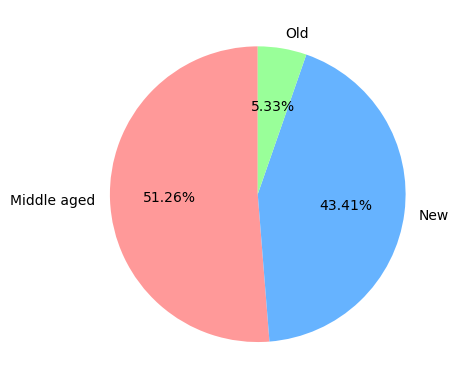

In [35]:
group_counts = trainset['age_group'].value_counts()
plt.pie(x=group_counts, 
        labels=group_counts.index,
        autopct='%1.2f%%',
        colors=['#ff9999','#66b3ff','#99ff99'],
        startangle=90)
plt.show()

<BarContainer object of 3 artists>

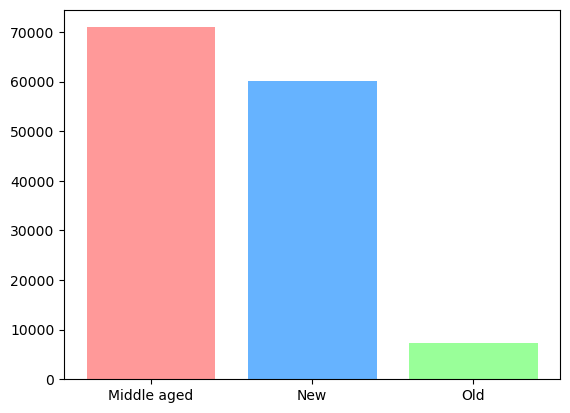

In [36]:
plt.bar(x=['Middle aged', 'New', 'Old'],
        height=group_counts,
        color=['#ff9999','#66b3ff','#99ff99'])

In [37]:
brand_cols = trainset.brand.unique()
print(brand_cols)

['Genesis' 'Audi' 'Chevrolet' 'Ford' 'BMW' 'Tesla' 'Cadillac' 'Land'
 'Mercedes-Benz' 'GMC' 'Hyundai' 'Volvo' 'Volkswagen' 'Buick' 'RAM' 'Alfa'
 'INFINITI' 'Jeep' 'Porsche' 'Toyota' 'Honda' 'MINI' 'Nissan' 'Jaguar'
 'Acura' 'Lincoln' 'Kia' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Lexus'
 'Bentley' 'Mazda' 'Subaru' 'Dodge' 'McLaren' 'Rivian' 'Chrysler'
 'Mitsubishi' 'Lamborghini' 'Ferrari' 'Aston' 'Hummer' 'Lotus' 'Scion'
 'Saturn' 'Karma' 'Lucid' 'Suzuki' 'FIAT' 'Saab' 'Polestar' 'Mercury'
 'Maybach' 'Bugatti' 'smart']


In [38]:
group_brand = trainset.groupby('brand')['id'].count().sort_values(ascending=False)
group_brand.reset_index()

brand     id
0            Ford  17241
1   Mercedes-Benz  15170
2             BMW  13433
3       Chevrolet  11216
4            Audi   9077
5            Land   7540
6         Porsche   7208
7           Lexus   6320
8          Toyota   5521
9            Jeep   4424
10       Cadillac   3574
11            RAM   3523
12          Tesla   3191
13       INFINITI   2670
14         Nissan   2661
15            GMC   2483
16            Kia   2063
17          Mazda   1920
18         Subaru   1823
19        Lincoln   1781
20        Hyundai   1573
21          Acura   1545
22          Dodge   1543
23     Volkswagen   1322
24          Honda   1217
25         Jaguar   1027
26        Genesis    787
27           MINI    779
28          Buick    744
29       Maserati    711
30           Alfa    577
31        Bentley    575
32          Volvo    550
33       Chrysler    422
34         Rivian    305
35    Lamborghini    277
36    Rolls-Royce    266
37     Mitsubishi    232
38        Pontiac    186
39        Ferrari    165
40         Hummer    153
41        McLaren    113
42          Aston    111
43         Saturn     93
44          Scion     87
45          Lucid     50
46           FIAT     33
47          Lotus     28
48          Karma     15
49           Saab     14
50        Mercury      7
51       Polestar      5
52         Suzuki      3
53        Bugatti      2
54        Maybach      1
55          smart      1

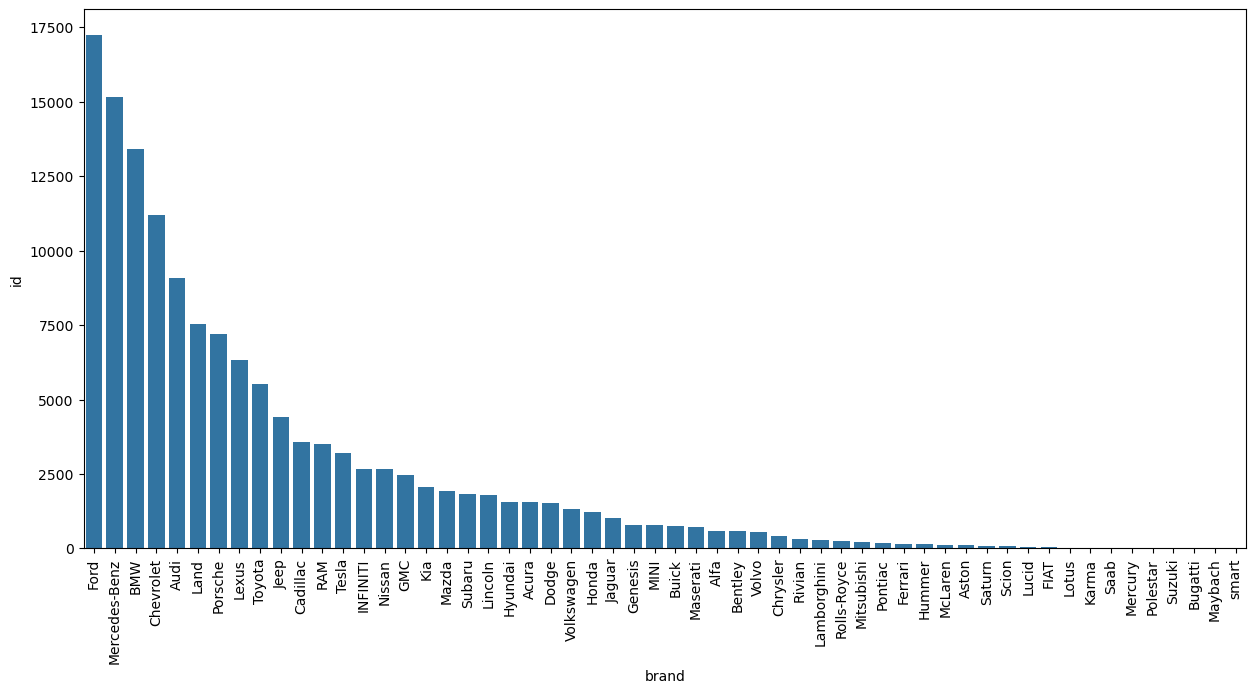

In [39]:
plt.figure(figsize=(15,7))
sns.barplot(data=group_brand.reset_index(),
            x='brand',
            y='id')
plt.xticks(rotation=90)
plt.show()

In [40]:
group_brand_price = trainset.groupby('brand')['price'].agg(['max', 'min', 'mean', 'median']).sort_values('max', ascending=False)
top_brands = group_brand_price.nlargest(20, columns='max') 
top_brands

max    min          mean   median
brand                                              
Cadillac       102000   3750  36563.729155  32000.0
BMW            101999   2300  36964.020546  32500.0
Mercedes-Benz  101999   2300  39457.655307  36000.0
Kia            101000   2800  33199.967523  32063.0
Lincoln        100000   3500  31839.035935  28500.0
Ford           100000   2500  37847.050171  35900.0
Land           100000   2300  40712.157029  38000.0
Porsche         99999   2899  43689.620699  39999.0
Lexus           99999   2300  32842.150316  29900.0
Maserati        99999   6099  43439.385373  41400.0
Tesla           99999   7500  47706.239423  46000.0
McLaren         99999  16998  57254.946903  56900.0
Lamborghini     99950   4500  56049.079422  57300.0
Nissan          99900   2500  28536.886133  22500.0
Chevrolet       99900   2500  39317.340317  37000.0
Jaguar          99900   4200  41842.502434  39500.0
Audi            99900   2300  34073.214829  30000.0
Toyota          99900   2000  32209.792429  30000.0
Dodge           99750   2300  37819.075178  35900.0
GMC             99750   2500  37219.903343  35000.0

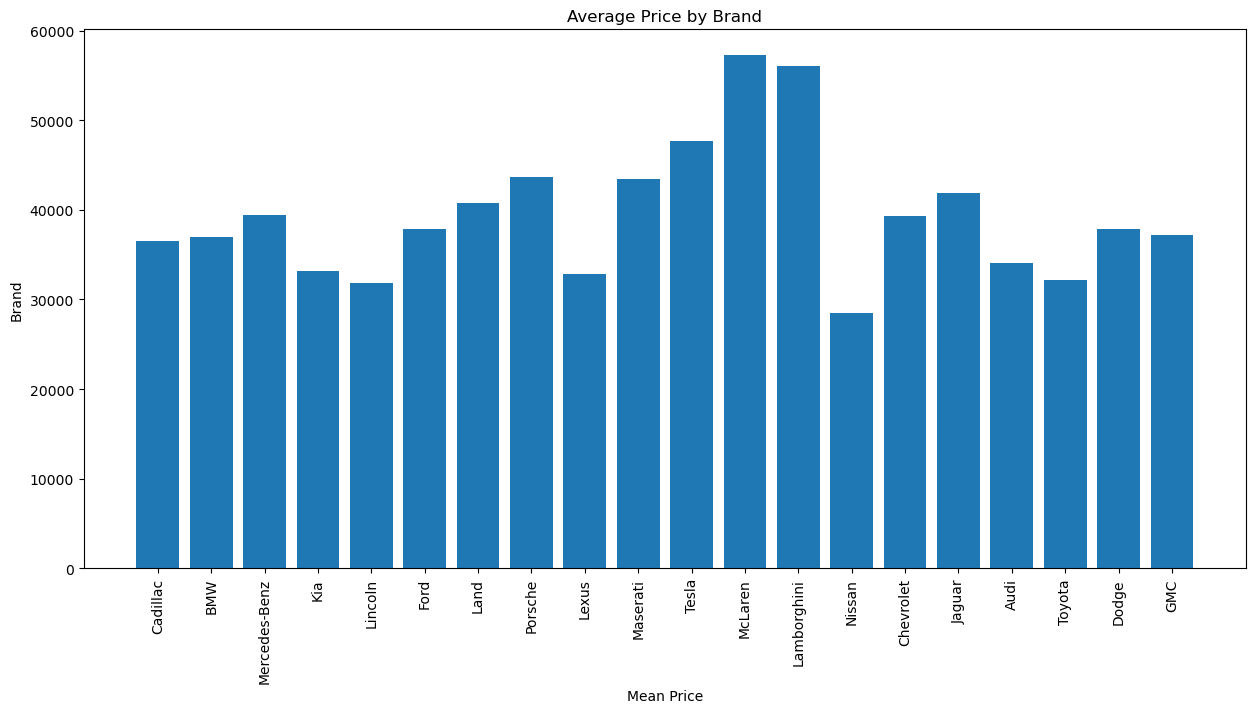

In [41]:
plt.figure(figsize=(15,7))

plt.bar(x=top_brands.index,
    height=top_brands['mean'])
plt.xticks(rotation=90)
plt.title('Average Price by Brand')
plt.xlabel('Mean Price')
plt.ylabel('Brand')

plt.show()

# Fuel analysis


In [42]:
group_fuel = trainset.groupby('fuel_type')
group_fuel['id'].count()

fuel_type
Diesel        2613
Electric      4252
Flex          3434
Gasoline    124867
Hybrid        3192
Name: id, dtype: int64

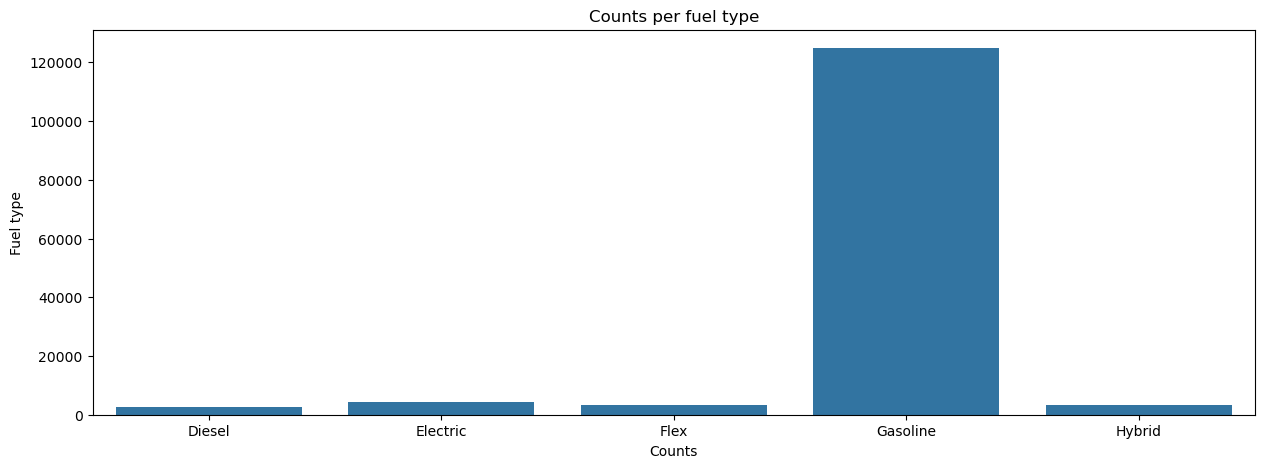

In [43]:
plt.figure(figsize=(15, 5))

sns.barplot(data=group_fuel['id'].count().reset_index(),
           x='fuel_type',
           y='id')
plt.xlabel('Counts')
plt.ylabel('Fuel type')
plt.title('Counts per fuel type')
plt.show()

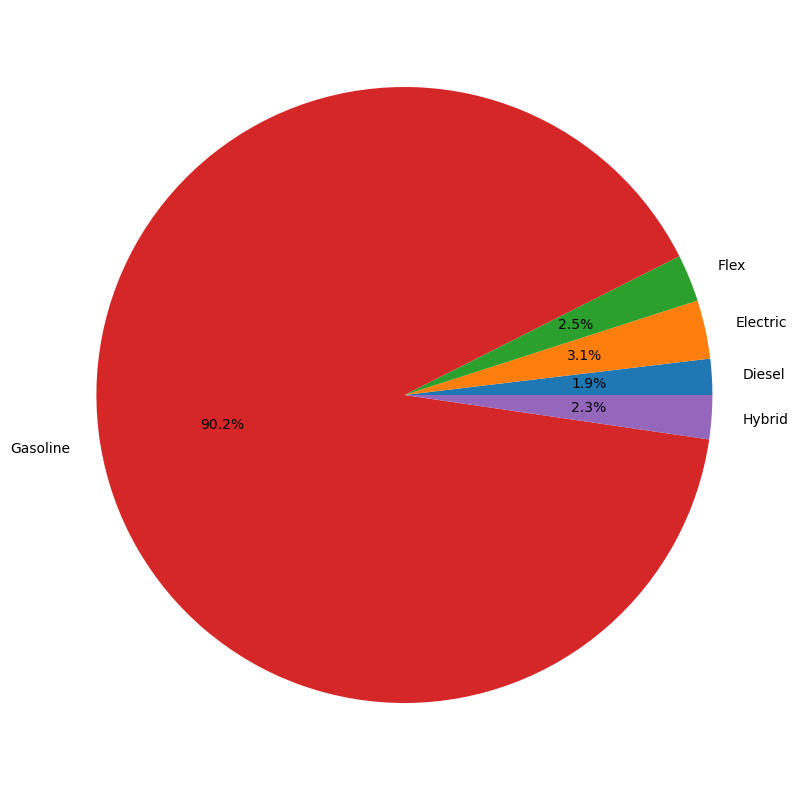

In [44]:
plt.figure(figsize=(10,10))
plt.pie(x=group_fuel['id'].count(),
        labels=['Diesel', 'Electric', 'Flex', 'Gasoline', 'Hybrid'],
        autopct='%1.1f%%',
        )

plt.show()

# Heatmap and Correlation Analysis

In [45]:
numeric = trainset.select_dtypes(include='number').drop(columns='id')


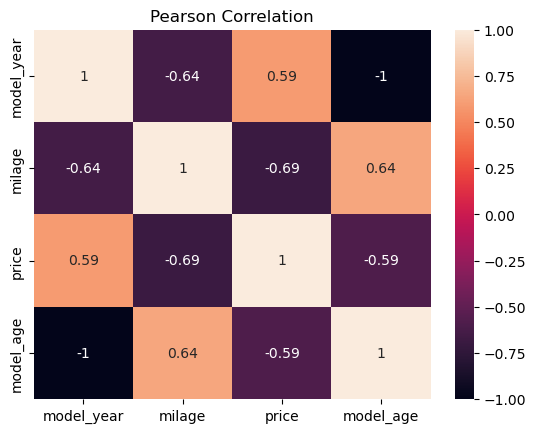

In [46]:
# Pearson correlation is good for linearly correlated items
corr = numeric.corr(method='pearson')
sns.heatmap(corr, annot=True)
plt.title('Pearson Correlation')
plt.show()

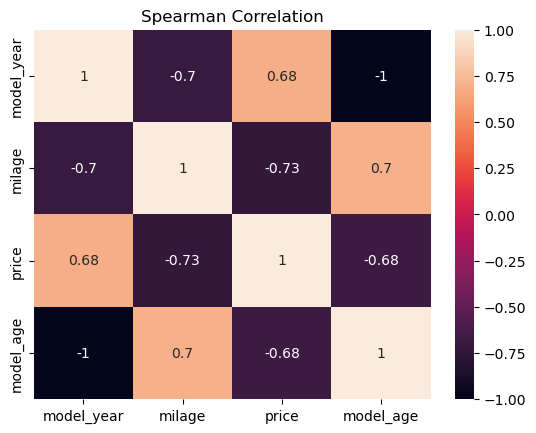

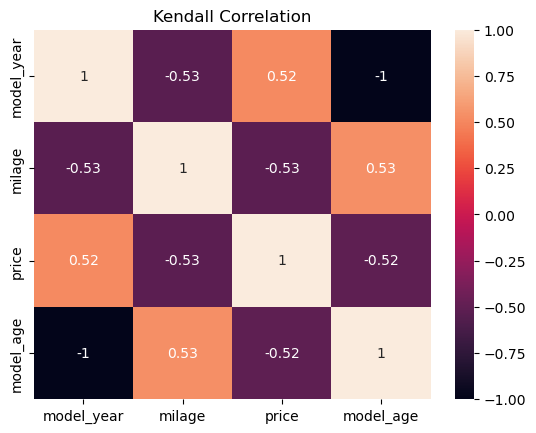

In [48]:
# Kentall (tau) correlation is used when we have ordinal data.
# Spearman correlation is appropriate for not normally distributed data.

# Both Kendall and Spearman correlations display the monotonic correlation between variables.
# Kendall works best for ordinal data.

# Also, Spearman is good for cases where we have outliers. In this case we cleaned the outliers earlier, untying our hands with removing the need to deal with extreme values.
# If we were more conservative to calculations, we could include them but we would lose other ways to analyze our data correlations.
corr_spearman = numeric.corr(method='spearman')
sns.heatmap(corr_spearman, annot=True)
plt.title('Spearman Correlation')
plt.show()

corr_kendall = numeric.corr(method='kendall')
sns.heatmap(corr_kendall, annot=True)
plt.title('Kendall Correlation')
plt.show()

# We can clearly see 

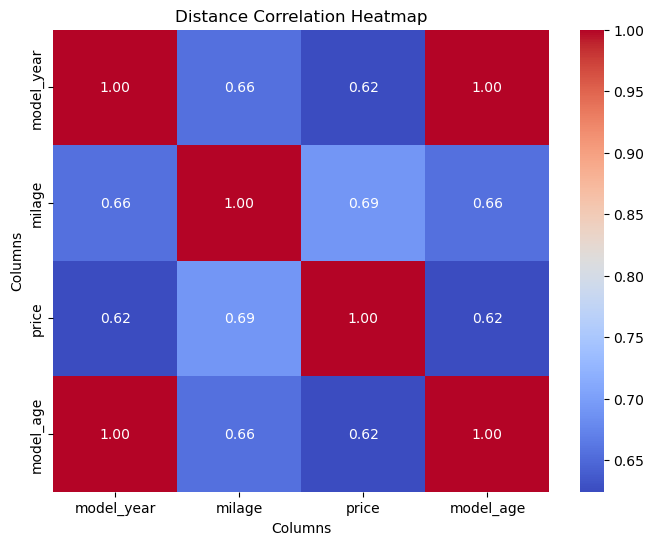

In [49]:
# Normalize numeric data
numeric = trainset.drop(columns=['id']).select_dtypes(include='number').to_numpy()
numeric_normalized = MinMaxScaler().fit_transform(numeric)

# Calculate distance correlation matrix
n_cols = numeric_normalized.shape[1]
dcor_matrix = np.zeros((n_cols, n_cols))

for i in range(n_cols):
    for j in range(n_cols):
        dcor_matrix[i, j] = dcor.distance_correlation(numeric_normalized[:, i], numeric_normalized[:, j])

# Fix diagonal values to 1 and enforce symmetry
np.fill_diagonal(dcor_matrix, 1)
dcor_matrix = (dcor_matrix + dcor_matrix.T) / 2

# Visualize the distance correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    dcor_matrix, annot=True, cmap="coolwarm", fmt=".2f",
    xticklabels=trainset.select_dtypes(include='number').columns[1:],
    yticklabels=trainset.select_dtypes(include='number').columns[1:]
)
plt.title("Distance Correlation Heatmap")
plt.xlabel("Columns")
plt.ylabel("Columns")
plt.show()


In [50]:
# Distance correlation tells us about the correlation between variables in both linear and non linear cases.
# We should avoid features that are highly correlated with each other.
# For instance, we should avoid using both model_age and model_year for training ML models because one feature is derives from the other.

# Preprocess

In [51]:
trainset.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'model_age', 'age_group'],
      dtype='object')

In [52]:
columns_to_drop = ['id', 'brand', 'model', 'model_year', 'engine' ,'int_col', 'ext_col', 'fuel_type']
train_set = trainset.copy()
train_set.drop(columns=columns_to_drop, axis=1, inplace=True)

In [53]:
column_list = ['milage', 'clean_title', 'model_age', 'price']
train_set = train_set[column_list]

In [54]:
train_set

milage clean_title  model_age  price
3        19500         Yes          7  45000
5        40950         Yes          6  29950
6        62200         Yes          8  28500
7       102604         Yes          8  12500
8        38352         Yes          4  62890
...        ...         ...        ...    ...
187749   49000         Yes          7  27500
187750   28600         Yes          6  30000
187751   13650         Yes          3  86900
187752   13895         Yes          2  84900
187753   59500         Yes          8  28995

[138358 rows x 4 columns]

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), ['clean_title']),
        ('num', StandardScaler(), ['milage'])
    ],
    remainder='passthrough'  
)



In [56]:
X_train, X_test, y_train, y_test = train_test_split(train_set.iloc[:,:-1], train_set.iloc[:, -1])

In [57]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [58]:
[X_train.shape, X_test.shape]

[(103768, 4), (34590, 4)]

# ML Model Testing

In [90]:
# We will follow the ML production methodology to figure out which ML models fit our data.
# We will create a dictionary with key:value pairs for the models

# For time saving due to resources shortage we will use some of the available models.
base_estimators = [
    ('ridge', Ridge()),
    ('lasso', Lasso())
]

# Define the models dictionary
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'BaggingRegressor': BaggingRegressor(),
    'StackingRegressor': StackingRegressor(estimators=base_estimators),
    'VotingRegressor': VotingRegressor(estimators=base_estimators),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': LGBMRegressor(),
    'CatBoostRegressor': CatBoostRegressor(verbose=False)
}


In [91]:
# Let's train and evaluate all the models in the list
model_scores = {}

for name, model in models.items():
    print(f"Training {name}...")
    try:
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate the model
        score = mean_squared_error(y_test, y_pred)
        model_scores[name] = score
        
        print(f"{name} MAE: {score:.4f}")
    except Exception as e:
        print(f"Error training {name}: {e}")

# Display all model scores
print("\nModel Performance Summary:")
for name, score in model_scores.items():
    print(f"{name}: MSE Score = {score:.4f}")

Training LinearRegression...
LinearRegression R2 Score: 180223044.7559
Training Ridge...
Ridge R2 Score: 180223019.9854
Training Lasso...
Lasso R2 Score: 180222210.7287
Training ElasticNet...
ElasticNet R2 Score: 191853208.6397
Training KNeighborsRegressor...
KNeighborsRegressor R2 Score: 186437705.3373
Training DecisionTreeRegressor...
DecisionTreeRegressor R2 Score: 191729047.7707
Training RandomForestRegressor...
RandomForestRegressor R2 Score: 175875754.1303
Training GradientBoostingRegressor...
GradientBoostingRegressor R2 Score: 167610369.4368
Training AdaBoostRegressor...
AdaBoostRegressor R2 Score: 183368367.0815
Training ExtraTreesRegressor...
ExtraTreesRegressor R2 Score: 186050618.8727
Training BaggingRegressor...
BaggingRegressor R2 Score: 178987402.7382
Training StackingRegressor...
StackingRegressor R2 Score: 180343063.1254
Training VotingRegressor...
VotingRegressor R2 Score: 180222601.1992
Training XGBRegressor...
XGBRegressor R2 Score: 166604480.5067
Training LGBMRegre

In [92]:
mlp = MLPRegressor(hidden_layer_sizes= (50,50), 
                  activation='relu', 
                  n_iter_no_change=10,
                  verbose=True,
                  max_iter=100,
                  learning_rate='adaptive',
                  )
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
score = r2_score(y_test, y_pred)
print(score)

Iteration 1, loss = 801595118.56311786
Iteration 2, loss = 442886799.30568016
Iteration 3, loss = 302134932.04074717
Iteration 4, loss = 181503516.76919630
Iteration 5, loss = 115210100.15998855
Iteration 6, loss = 102598954.72890671
Iteration 7, loss = 97481749.65266277
Iteration 8, loss = 94004365.09132585
Iteration 9, loss = 91701168.80538389
Iteration 10, loss = 90412454.50211415
Iteration 11, loss = 89815122.56651327
Iteration 12, loss = 89591738.55013947
Iteration 13, loss = 89489893.18569064
Iteration 14, loss = 89376743.08372299
Iteration 15, loss = 89305999.29426248
Iteration 16, loss = 89249073.03237651
Iteration 17, loss = 89164559.43147461
Iteration 18, loss = 89092512.74530892
Iteration 19, loss = 89011089.52345310
Iteration 20, loss = 88924238.22169237
Iteration 21, loss = 88808306.44009691
Iteration 22, loss = 88705040.50812651
Iteration 23, loss = 88578281.18052699
Iteration 24, loss = 88456346.82939018
Iteration 25, loss = 88335565.78973576
Iteration 26, loss = 8822089

/home/admin1997/miniconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [93]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, cv=10, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
    plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Score')
    plt.xlabel('Training Size')
    plt.ylabel('R2 score')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

def plot_residuals(model, X, y):
    y_pred = model.predict(X)
    residuals = y - y_pred

    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()



def evaluate_model_cv(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='r2')
    print(f"CV Scores: {scores}")
    print(f"Mean Score: {np.mean(scores):.4f}, Std Dev: {np.std(scores):.4f}")


Evaluating Model: LinearRegression
Cross-Validation for LinearRegression:
CV Scores: [0.51948938 0.50959446 0.51686175 0.51099872 0.52157526 0.52157764
 0.5231807  0.51164158 0.51562928 0.51274493]
Mean Score: 0.5163, Std Dev: 0.0047
--------------------------------------------------
Plotting Learning Curve for LinearRegression...


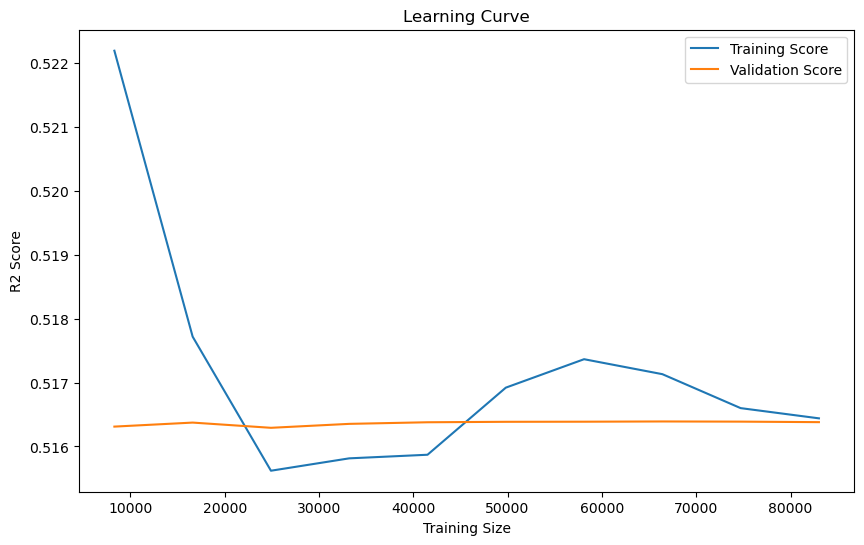

Plotting Residuals for LinearRegression...


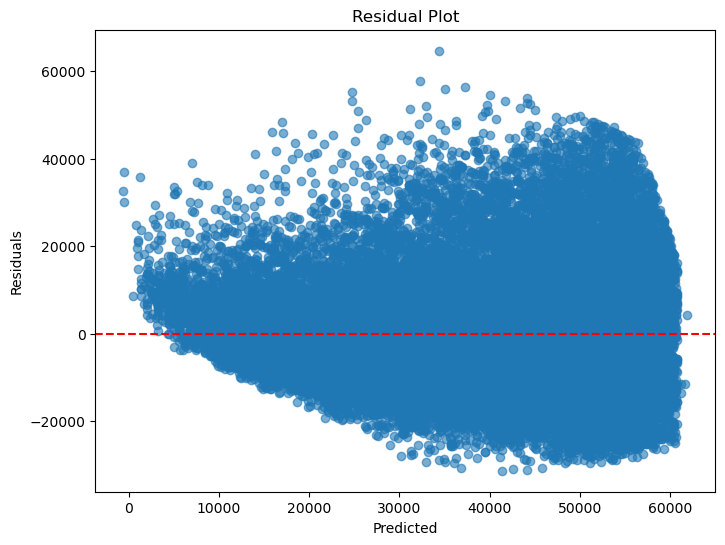

Evaluating Model: Ridge
Cross-Validation for Ridge:
CV Scores: [0.51948945 0.50959454 0.51686182 0.51099867 0.52157525 0.52157766
 0.52318073 0.5116417  0.5156291  0.51274482]
Mean Score: 0.5163, Std Dev: 0.0047
--------------------------------------------------
Plotting Learning Curve for Ridge...


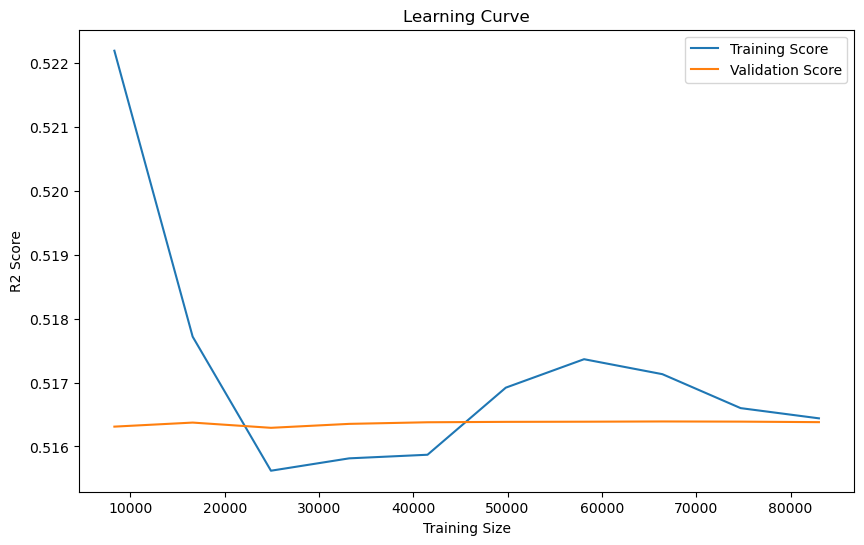

Plotting Residuals for Ridge...


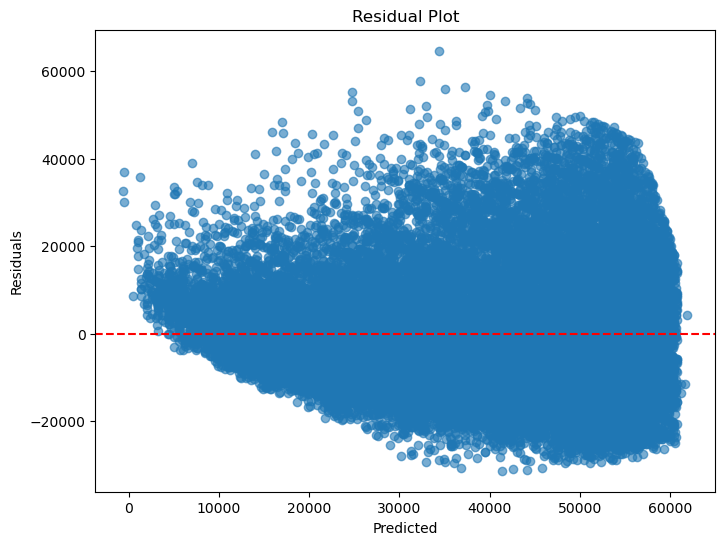

Evaluating Model: Lasso
Cross-Validation for Lasso:
CV Scores: [0.51949703 0.50959386 0.51686527 0.51099422 0.52157661 0.52157082
 0.52317709 0.5116414  0.51562562 0.51275083]
Mean Score: 0.5163, Std Dev: 0.0047
--------------------------------------------------
Plotting Learning Curve for Lasso...


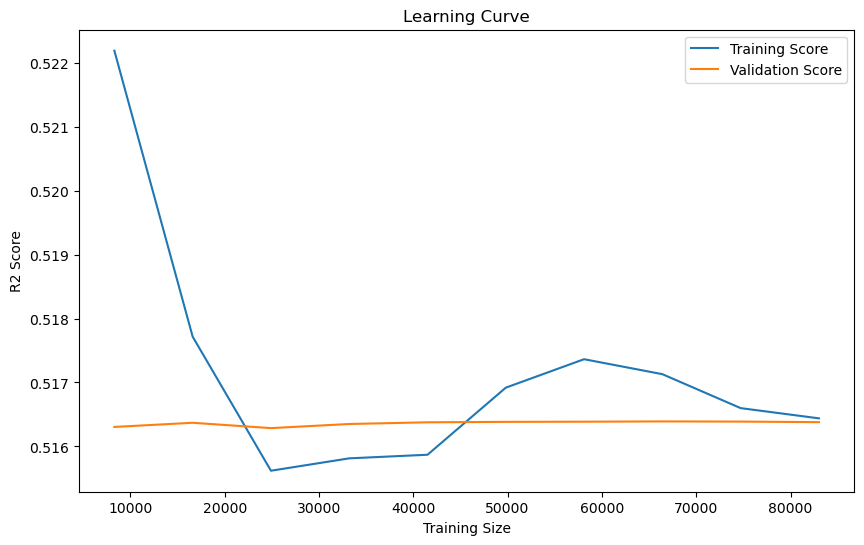

Plotting Residuals for Lasso...


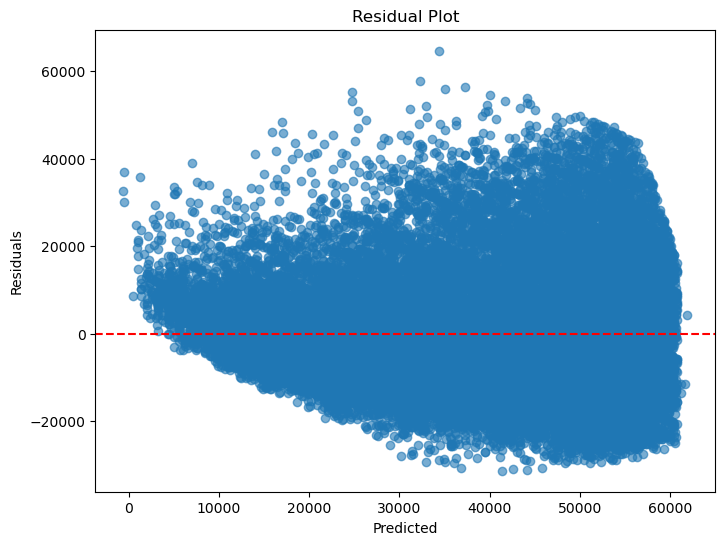

Evaluating Model: ElasticNet
Cross-Validation for ElasticNet:
CV Scores: [0.48721583 0.47790977 0.4851609  0.47770453 0.48826662 0.49097915
 0.49141042 0.48074303 0.47987955 0.47569326]
Mean Score: 0.4835, Std Dev: 0.0055
--------------------------------------------------
Plotting Learning Curve for ElasticNet...


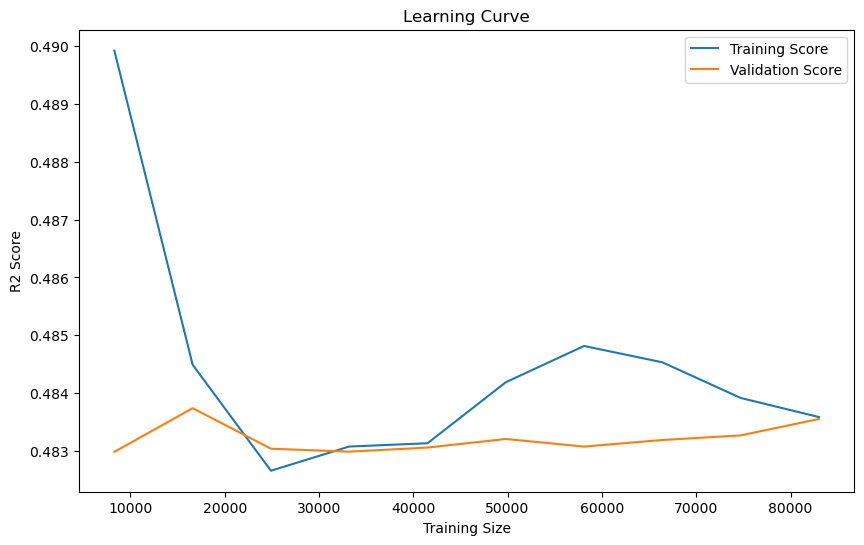

Plotting Residuals for ElasticNet...


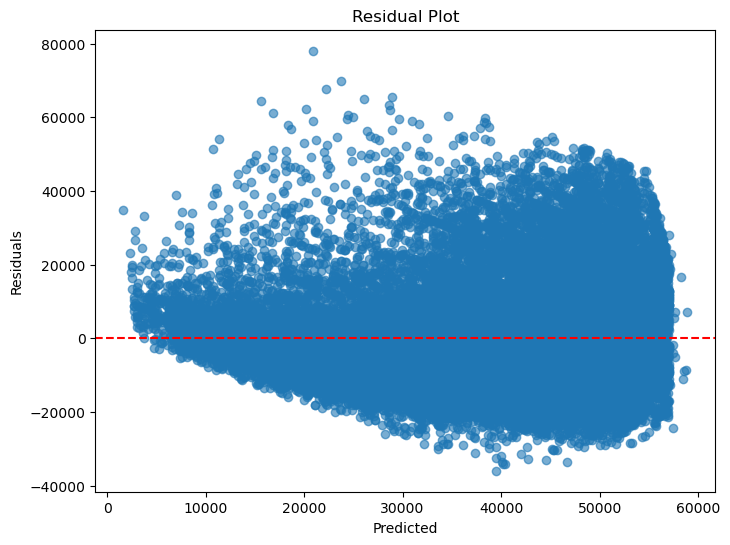

Evaluating Model: KNeighborsRegressor
Cross-Validation for KNeighborsRegressor:
CV Scores: [0.5018413  0.48862352 0.48814235 0.49297985 0.51111393 0.50343104
 0.50272203 0.49723457 0.5033612  0.50450128]
Mean Score: 0.4994, Std Dev: 0.0071
--------------------------------------------------
Plotting Learning Curve for KNeighborsRegressor...


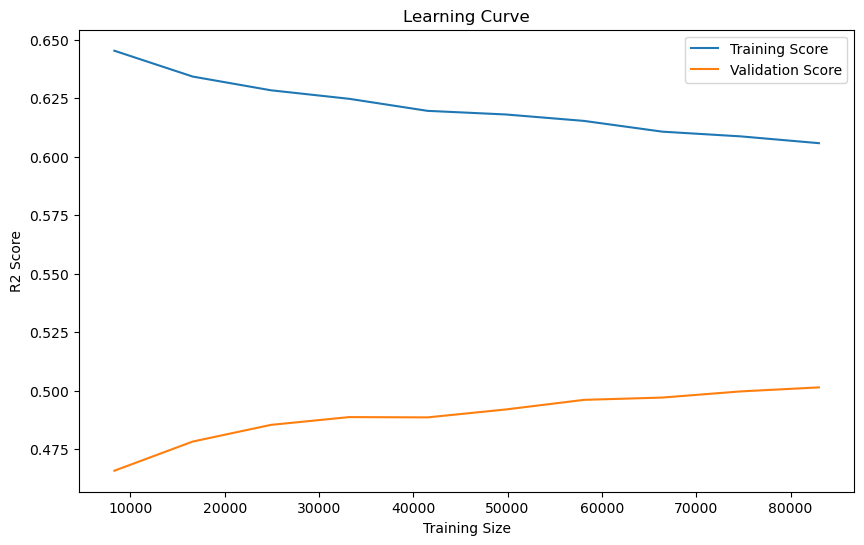

Plotting Residuals for KNeighborsRegressor...


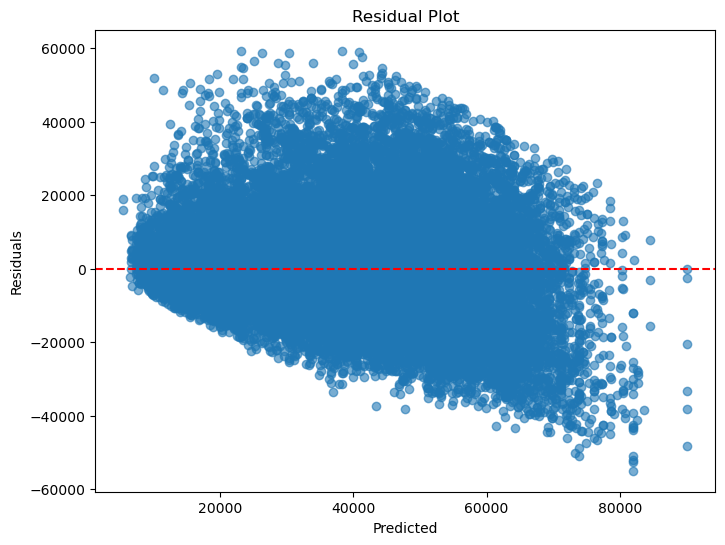

Evaluating Model: DecisionTreeRegressor
Cross-Validation for DecisionTreeRegressor:
CV Scores: [0.48357523 0.45928784 0.47098002 0.46947367 0.48252189 0.48376772
 0.48864512 0.4725023  0.48385535 0.4825757 ]
Mean Score: 0.4777, Std Dev: 0.0087
--------------------------------------------------
Plotting Learning Curve for DecisionTreeRegressor...


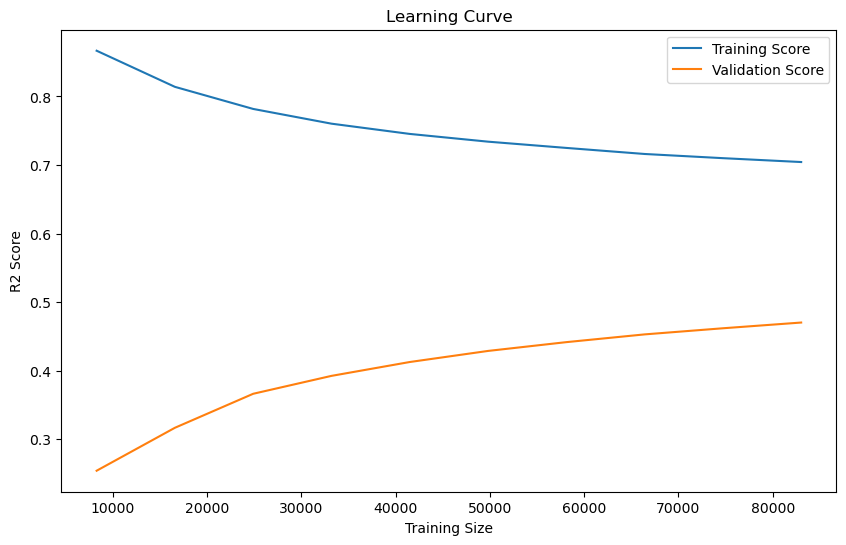

Plotting Residuals for DecisionTreeRegressor...


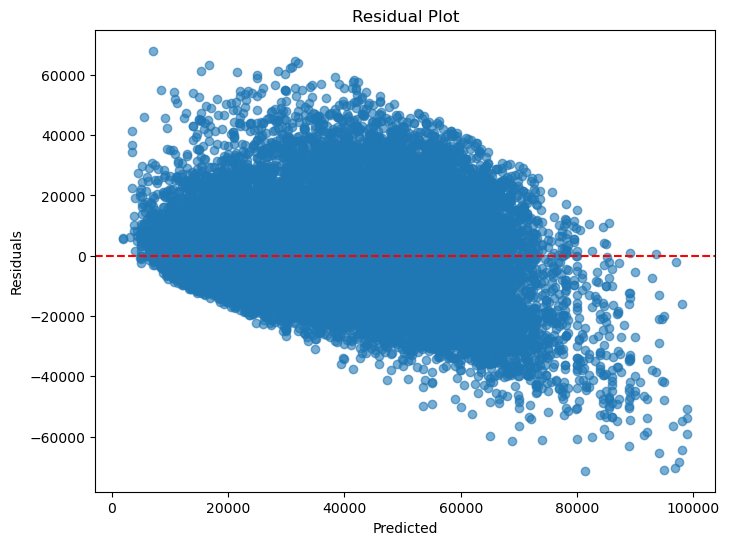

Evaluating Model: RandomForestRegressor
Cross-Validation for RandomForestRegressor:
CV Scores: [0.52793085 0.51214867 0.51816238 0.51298212 0.53270242 0.52724194
 0.53399799 0.51958851 0.52509653 0.52953752]
Mean Score: 0.5239, Std Dev: 0.0074
--------------------------------------------------
Plotting Learning Curve for RandomForestRegressor...


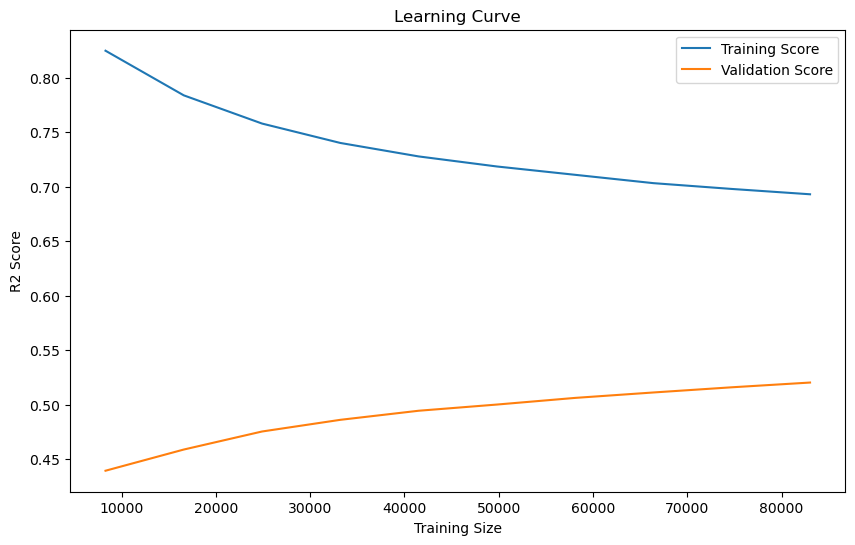

Plotting Residuals for RandomForestRegressor...


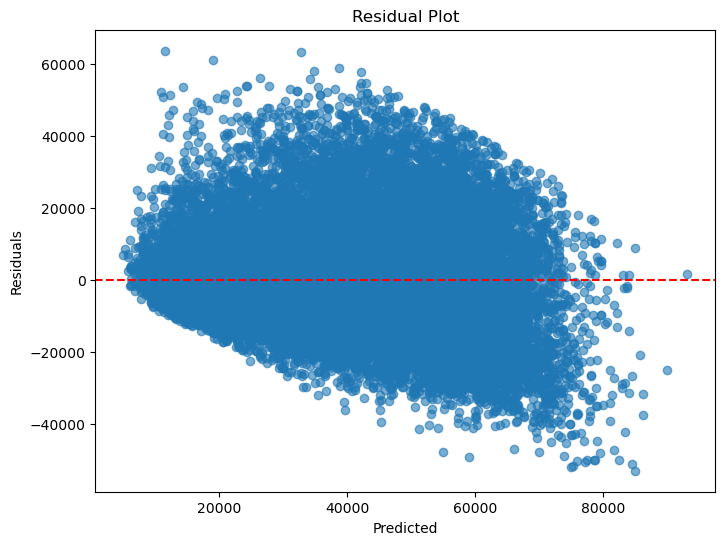

Evaluating Model: GradientBoostingRegressor
Cross-Validation for GradientBoostingRegressor:
CV Scores: [0.55530319 0.54450018 0.55130136 0.54593059 0.56081258 0.55746922
 0.55857157 0.54479    0.55584422 0.55401779]
Mean Score: 0.5529, Std Dev: 0.0056
--------------------------------------------------
Plotting Learning Curve for GradientBoostingRegressor...


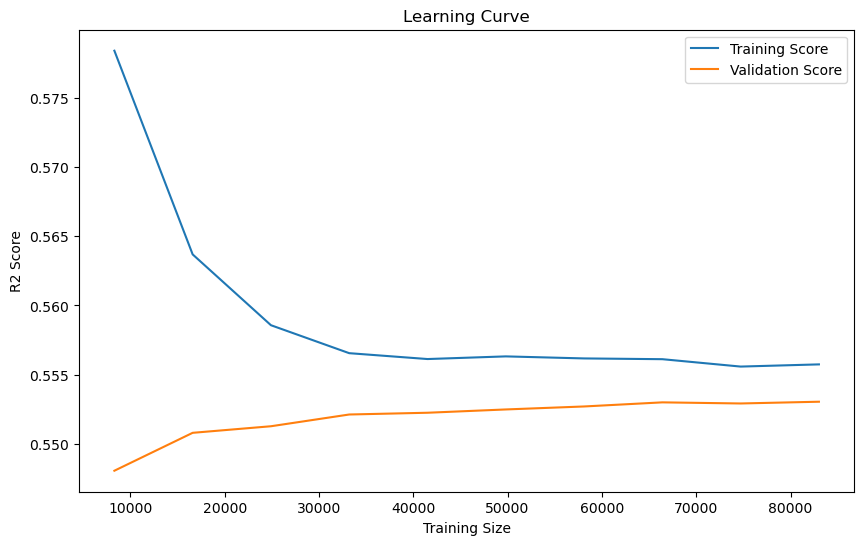

Plotting Residuals for GradientBoostingRegressor...


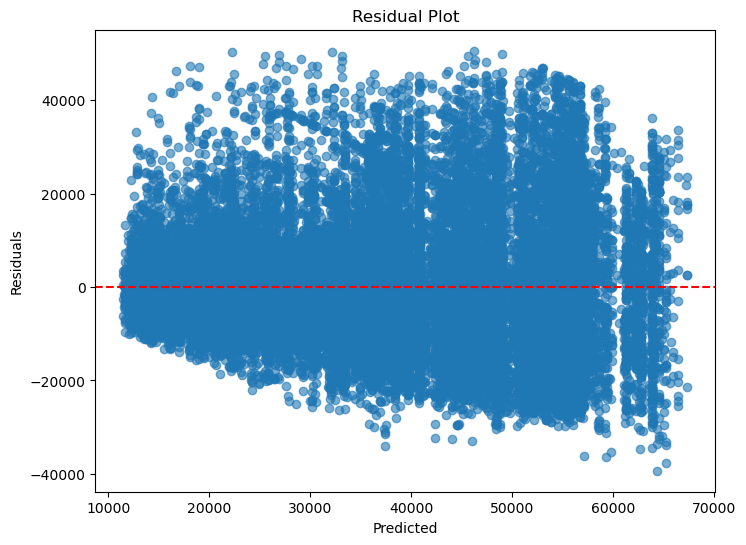

Evaluating Model: AdaBoostRegressor
Cross-Validation for AdaBoostRegressor:
CV Scores: [0.51115527 0.50249057 0.51236953 0.50604381 0.52388364 0.5149416
 0.50965861 0.51140547 0.51929698 0.51559928]
Mean Score: 0.5127, Std Dev: 0.0059
--------------------------------------------------
Plotting Learning Curve for AdaBoostRegressor...


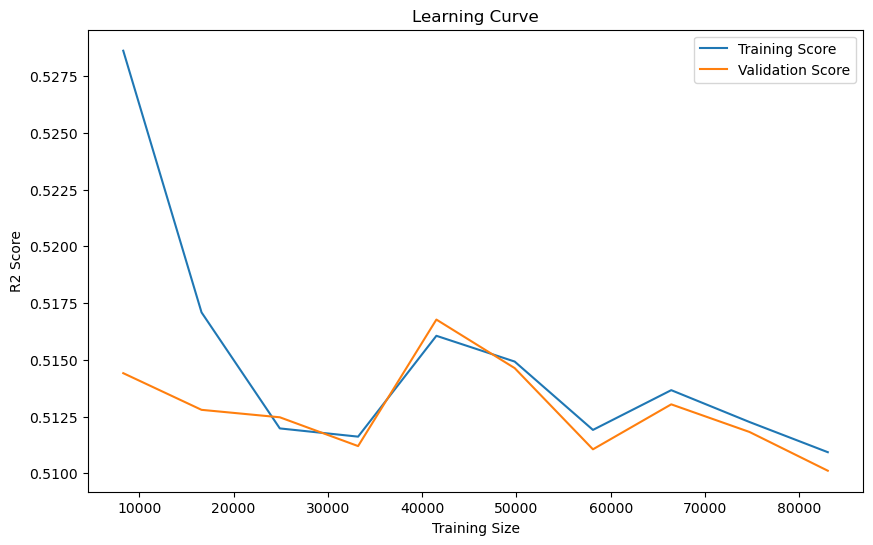

Plotting Residuals for AdaBoostRegressor...


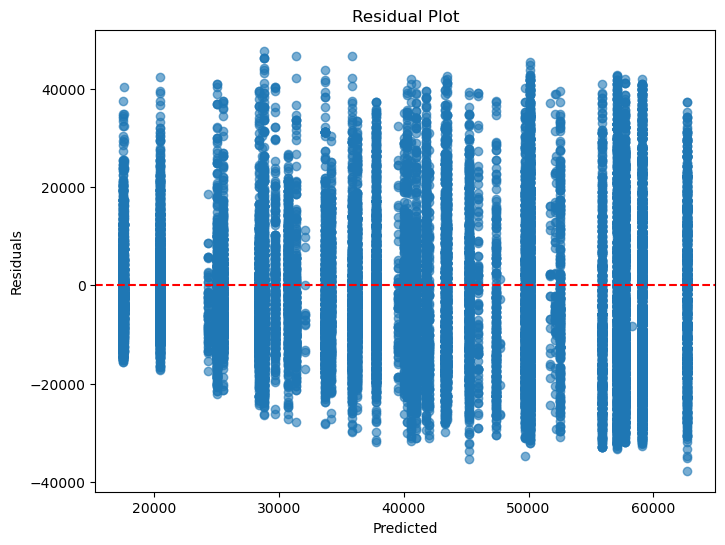

Evaluating Model: ExtraTreesRegressor
Cross-Validation for ExtraTreesRegressor:
CV Scores: [0.49626743 0.47955841 0.48725693 0.48622831 0.50270317 0.4976358
 0.50226092 0.4878836  0.49950935 0.50010419]
Mean Score: 0.4939, Std Dev: 0.0076
--------------------------------------------------
Plotting Learning Curve for ExtraTreesRegressor...


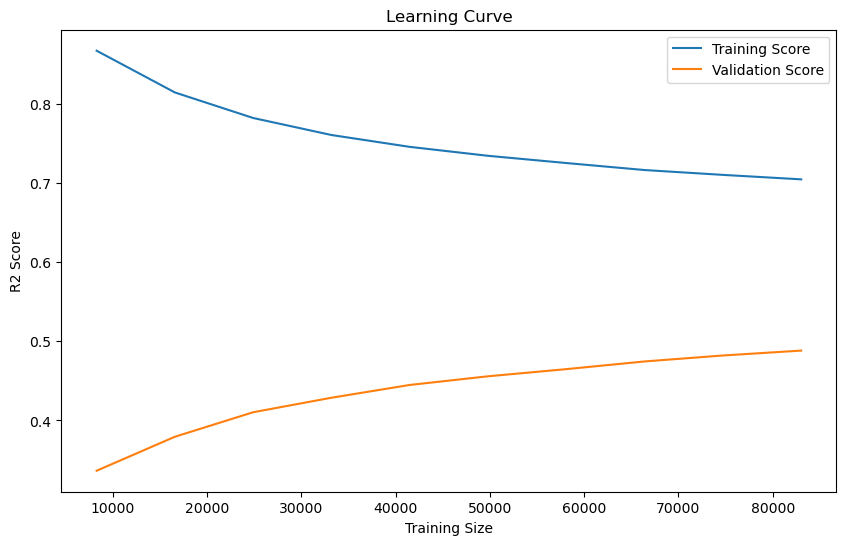

Plotting Residuals for ExtraTreesRegressor...


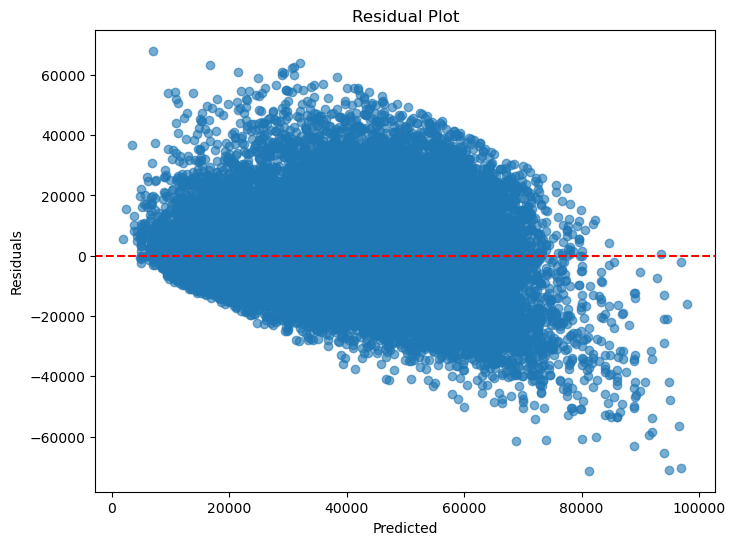

Evaluating Model: BaggingRegressor
Cross-Validation for BaggingRegressor:
CV Scores: [0.52102737 0.5033117  0.50913656 0.50470549 0.52253861 0.52066461
 0.52471268 0.51323898 0.51748376 0.5220963 ]
Mean Score: 0.5159, Std Dev: 0.0074
--------------------------------------------------
Plotting Learning Curve for BaggingRegressor...


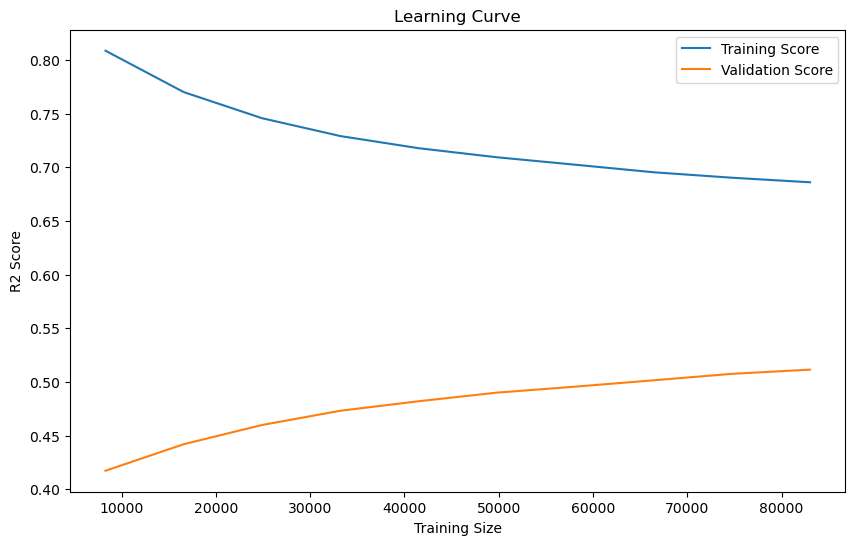

Plotting Residuals for BaggingRegressor...


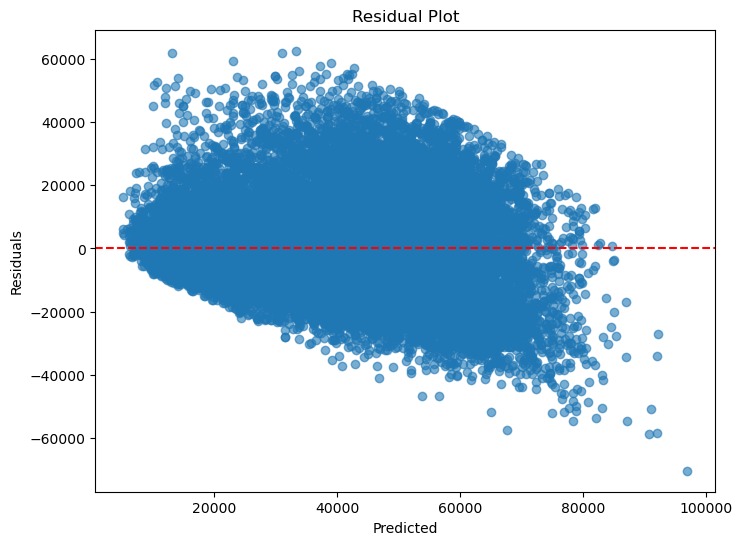

Evaluating Model: StackingRegressor
Cross-Validation for StackingRegressor:
CV Scores: [0.51946406 0.50967837 0.51685865 0.51098436 0.52164198 0.52134226
 0.52316776 0.51166844 0.51564974 0.51267721]
Mean Score: 0.5163, Std Dev: 0.0047
--------------------------------------------------
Plotting Learning Curve for StackingRegressor...


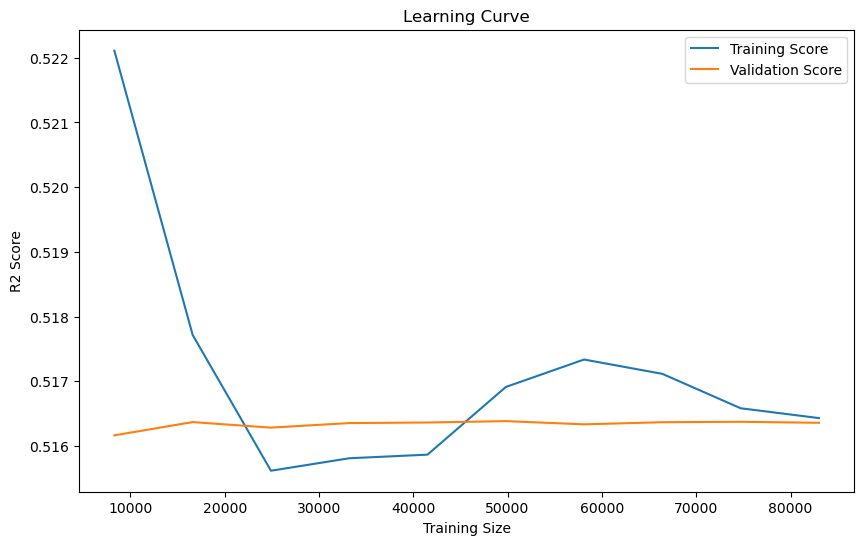

Plotting Residuals for StackingRegressor...


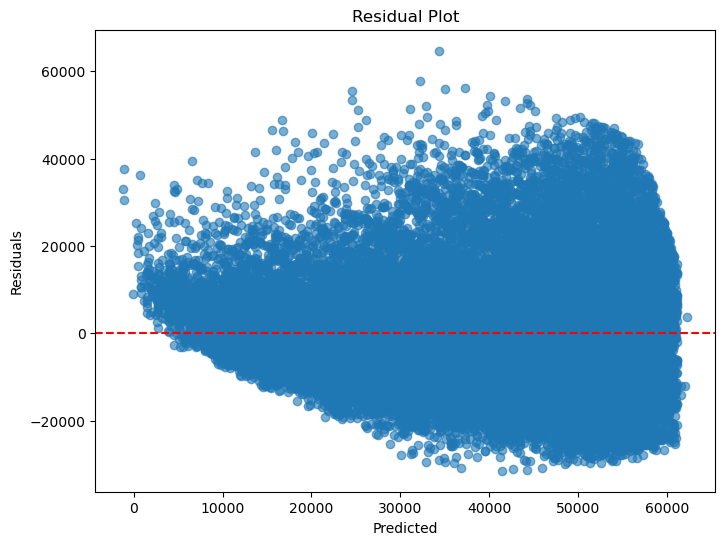

Evaluating Model: VotingRegressor
Cross-Validation for VotingRegressor:
CV Scores: [0.51949327 0.50959424 0.51686358 0.51099648 0.52157597 0.52157427
 0.52317894 0.51164158 0.5156274  0.51274786]
Mean Score: 0.5163, Std Dev: 0.0047
--------------------------------------------------
Plotting Learning Curve for VotingRegressor...


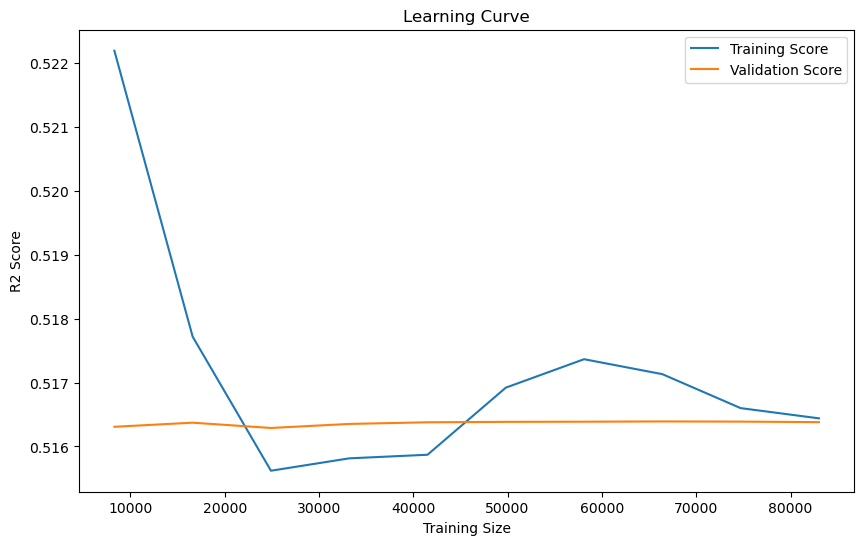

Plotting Residuals for VotingRegressor...


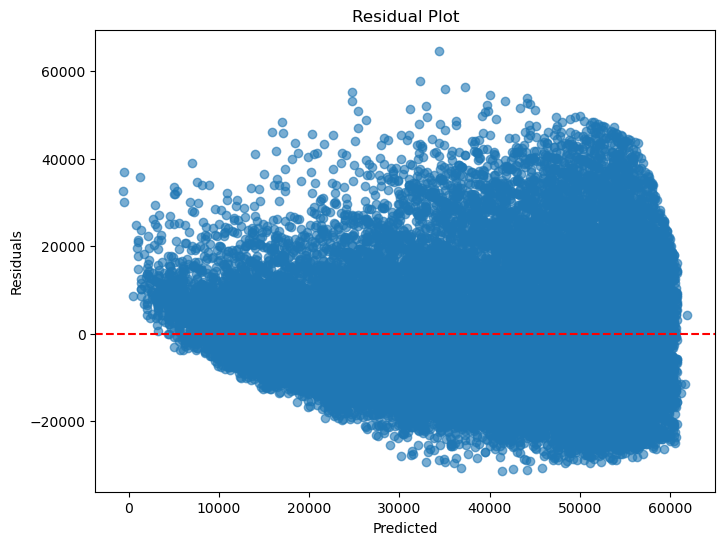

Evaluating Model: XGBRegressor
Cross-Validation for XGBRegressor:
CV Scores: [0.55663323 0.54329348 0.55362296 0.54609406 0.56522632 0.56223089
 0.55810058 0.54672801 0.55841893 0.55335057]
Mean Score: 0.5544, Std Dev: 0.0068
--------------------------------------------------
Plotting Learning Curve for XGBRegressor...


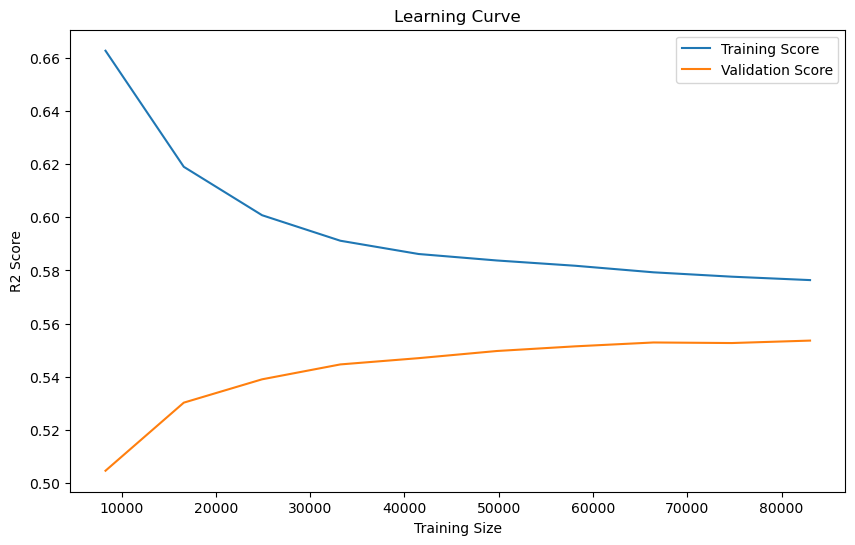

Plotting Residuals for XGBRegressor...


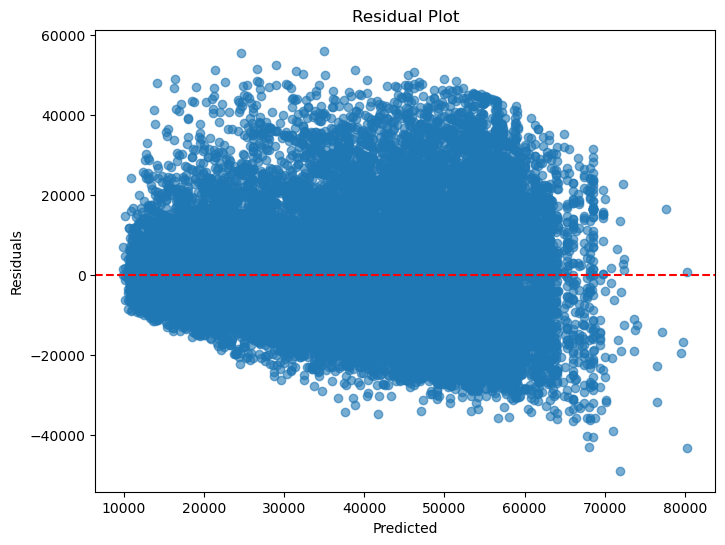

Evaluating Model: LGBMRegressor
Cross-Validation for LGBMRegressor:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 93391, number of used features: 4
[LightGBM] [Info] Start training from score 36842.776231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 93391, number of used features: 4
[LightGBM] [Info] Start training from score 36833.996831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

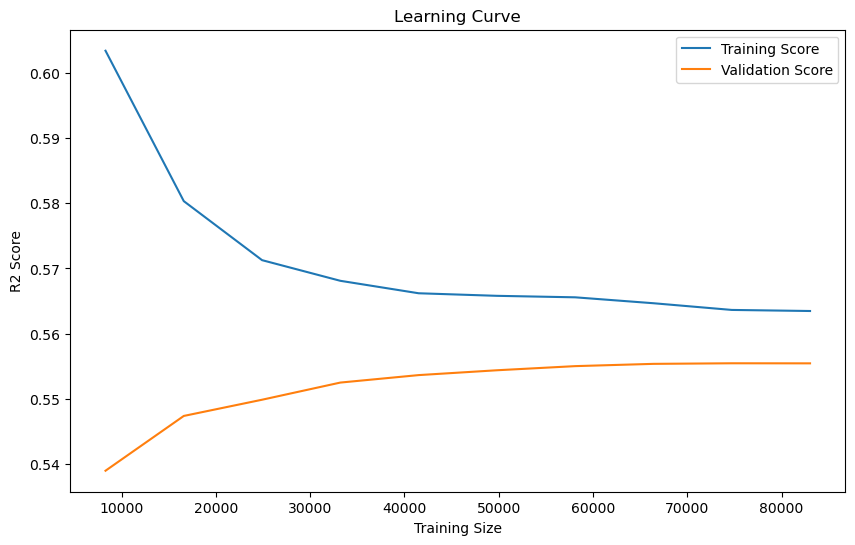

Plotting Residuals for LGBMRegressor...


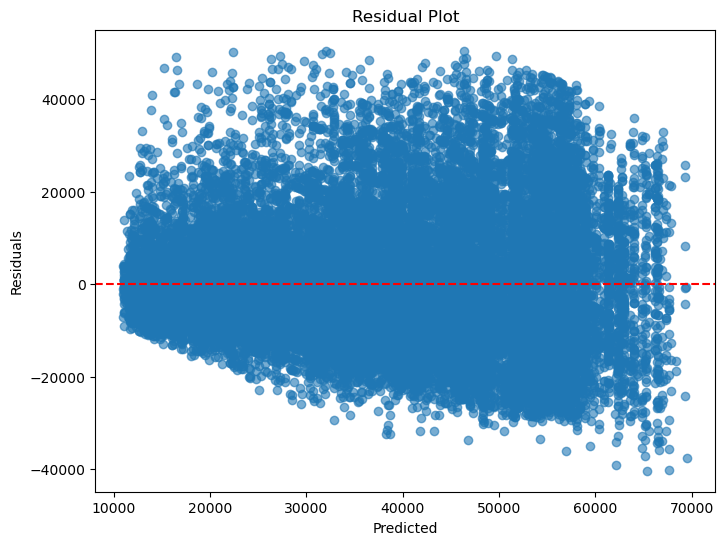

Evaluating Model: CatBoostRegressor
Cross-Validation for CatBoostRegressor:
CV Scores: [0.56141916 0.54790057 0.55657658 0.55001898 0.56680858 0.56391564
 0.56020516 0.54987968 0.56049486 0.559038  ]
Mean Score: 0.5576, Std Dev: 0.0061
--------------------------------------------------
Plotting Learning Curve for CatBoostRegressor...


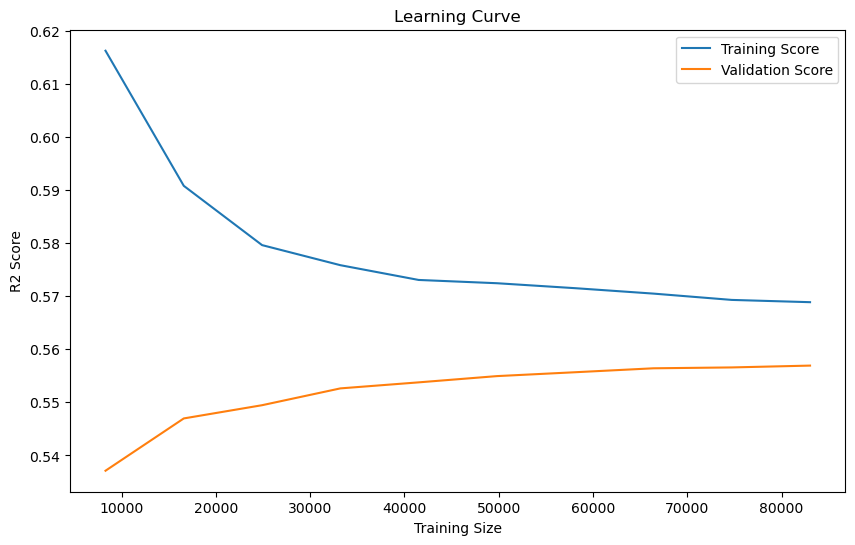

Plotting Residuals for CatBoostRegressor...


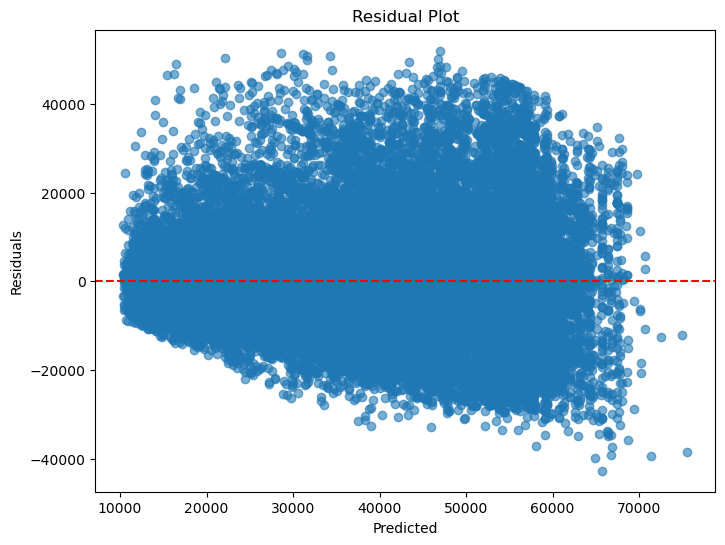

In [94]:
for name, model in models.items():
    print(f"Evaluating Model: {name}")
    print("=" * 50)
    
    # Evaluate cross-validation scores
    print(f"Cross-Validation for {name}:")
    evaluate_model_cv(model, X_train, y_train)
    print("-" * 50)
    
    # Plot learning curve
    print(f"Plotting Learning Curve for {name}...")
    plot_learning_curve(model, X_train, y_train)
    
    # Plot residuals
    print(f"Plotting Residuals for {name}...")
    plot_residuals(model, X_test, y_test)
    
    print("=" * 50)
    plt.show()  # Ensure plots are displayed before moving to the next model


In [95]:
# None of the models are very great at generalizing
# If we had to choose from one of them it would be Catboost or XGBRegressor.
# Most likely there are more ways to study and explore the data before cleaning it more efficiently and achieving greater performances

# Build a simple NN

In [ ]:
# We will experiment with a custom ANN for regression.

In [59]:
# First we will define a function to automate the cleaning process
def prepare_test_set(df):
    df.loc[df['clean_title'].isna(), 'clean_title'] = 'No'
    df.loc[(df['clean_title'] == 'No') & (df['accident'] == 'None reported'), 'clean_title'] = 'Yes'

    df.loc[(df['accident'].isna()) & (df['clean_title'] == 'Yes'), 'accident'] = 'None reported'
    df[(df['accident'] == 'None reported') & (df['clean_title'] == 'No')]

    df[(df['accident'] == 'At least 1 accident or damage') & (df['clean_title'] == 'Yes')]
    df.loc[(df['accident'].isna()) & (df['clean_title'] == 'No'), 'accident'] = 'At least 1 accident or damage'

    df.loc[(df['fuel_type'].isna()) & (df['engine'].str.contains("Electric", case=False, na=False)), 'fuel_type'] = 'Electric' 
    df.loc[(df['fuel_type'].isna()) & (df['engine'].str.contains("Battery", case=False, na=False)), 'fuel_type'] = 'Electric'
    df.loc[(df['fuel_type'].isna()) & (df['brand'] == 'Tesla'), 'fuel_type'] = 'Electric' 
    df.loc[df['fuel_type'].str.contains("Flex", case=False, na=False), 'fuel_type'] = 'Flex' 
    
    df.loc[(df['fuel_type'].isna()) & (df['engine'].str.contains("Dual", case=False, na=False)), 'fuel_type'] = 'Hybrid' 
    df.loc[(df['fuel_type'].isna()) & (df['engine'].str.contains("Hybrid", case=False, na=False)), 'fuel_type'] = 'Hybrid' 
    df.loc[df['fuel_type'].str.contains("Plug", case=False, na=False), 'fuel_type'] = 'Hybrid' 

    df.loc[(df['fuel_type'].isna()) & (df['engine'].str.contains("Diesel", case=False, na=False)), 'fuel_type'] = 'Diesel' 
    df.loc[df.engine.str.contains(r'^\d+\.\d+L$'), 'fuel_type'] = 'Gasoline'
    df[(df['fuel_type'].isna()) & df.fuel_type.str.contains('Gasoline', case=False, na=False)] = 'Gasoline'
    df.loc[df.engine.str.contains('Gasoline', case=False, na=False), 'fuel_type'] = 'Gasoline'
    df.loc[df['fuel_type'].isna(), 'fuel_type'] = 'Gasoline'

    
    current_year = datetime.now().year
    df.loc[:, 'model_age'] = current_year - df.loc[:, 'model_year']

    df.loc[:, 'age_group'] = df.loc[:, 'model_age',].apply(define_age_group)

    cols_to_drop = ['id', 'brand', 'model', 'transmission', 'model_year', 'engine', 'clean_title', 'int_col', 'ext_col']
    df_return = df.copy()
    df_return.drop(cols_to_drop, axis=1, inplace=True)
    cols_list = ['milage', 'clean_title', 'model_age', 'price']

    df_return = df_return[cols_list]

    return df_return

In [60]:
# We will use the previously filtered data to initiate the same start as in the ML models
X_train[1]

array([0.        , 1.        , 0.98114571, 7.        ])

In [61]:
model = Sequential()
# 1st Hidden layer
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization()) # Batch Normalization reduces overfitting and improves performance
model.add(Dropout(0.1)) # Dropout layers help prevent overfitting
# 2nd Hidden layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu')) # introduce some non-linearity to the system
model.add(BatchNormalization())
model.add(Dropout(0.1))
# 3rd Hidden layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
# 4th Hidden layer
# model.add(Dense(512, input_dim=X_train.shape[1], activation='relu')) # introduce some non-linearity to the system
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
# # Output layer
model.add(Dense(1))
# One test pointed that the default value of learning rate is too high for the model to converge.
# We will explicitly state it to be 10 times smaller thatn the default 
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

/home/admin1997/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-20 16:52:19.681968: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [62]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1200, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1726482816.0000 - val_loss: 1730324224.0000
Epoch 2/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1723924992.0000 - val_loss: 1730151424.0000
Epoch 3/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1741431424.0000 - val_loss: 1730053760.0000
Epoch 4/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1723660672.0000 - val_loss: 1729962624.0000
Epoch 5/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1722226176.0000 - val_loss: 1729871360.0000
Epoch 6/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1731819008.0000 - val_loss: 1729747584.0000
Epoch 7/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1732845824.0000 - val_loss: 1729617024.0000
Epoch 8/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1724266368.0000 - val_loss: 1729480192.0000
Epoch 9/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1717656832.0000 - val_loss: 1729328512.0000
Epoch 10/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

1081/1081 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Squared Error: 1689313727.9190443
R2 Score: -3.5004611015319824


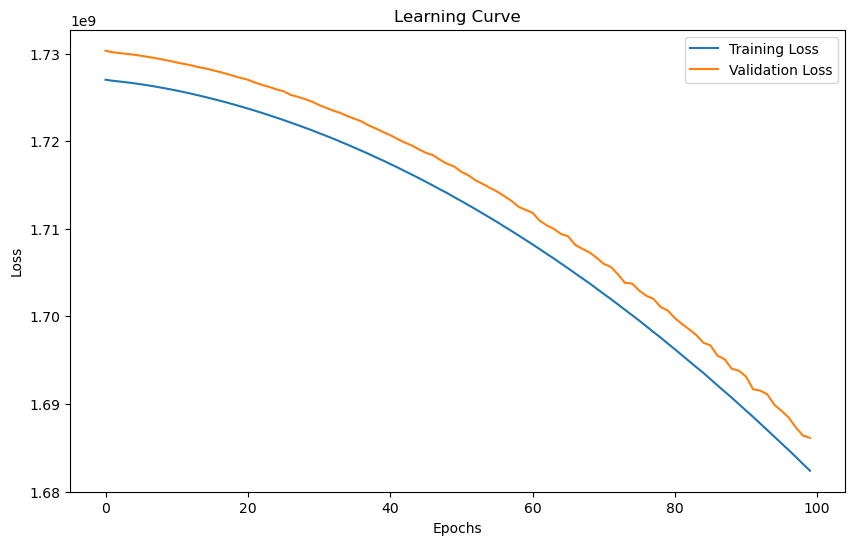

In [63]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# We clearly see a downward trend of the model. Given the amound of epochs we can expect it to converge even further. The values of the metrics
# show us that now good representation of the data has been achieved.
# Due to the lack of resources we cannot know or speculate what the extent of convergence could be.

In [ ]:
# test_set = prepare_test_set(testset)

# test_seta

# test_set = ct.transform(test_set)

# y_pred = model.predict(test_set)

# output = pd.DataFrame(data={
#     'id': testset.loc[:, 'id'],
#     'price': y_pred.reshape(-1,)
# }, )

# output.to_csv('./submission.csv', index=False)